### Install All the packages that are required

In [3]:
!pip install mysql-connector-python
!pip install matplotlib
!pip install scipy
!pip install statistics
!pip install numpy
!pip install seaborn
!pip install pandas

  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7454 sha256=4f8b22c10851dea6ebb8b585ed55cdf9133b92c8be5abbd6f2fbc5f1f5e9d377
  Stored in directory: c:\users\batsa\appdata\local\pip\cache\wheels\36\4b\c7\6af97584669b756c0d60c5ff05d5fb1f533a4e4d96e5ee92b9
Successfully built statistics


### Import all the packages and modules needed for Analysis

In [4]:
import mysql.connector
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.patches as mpatches
from scipy.stats import pearsonr


In [5]:
# Set an overall font size
sns.set(font_scale = 1.2)

### MySQL Connector
Connect to the 'search_analysis' database, and enter the required credentials for the user.

In [6]:
# Create an instance of the mysql connector.
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="4310",
    database = "search_analysis"
)

In [7]:
# Create a cursor for the database
myCursor = db.cursor()

### Initialize all the functions used across the analysis
The definitions of the functions are mentioned inside the function itself.

In [8]:
# For fetching keywords

def get_all_keywords():
    '''
        Fetch all the keywords from the Database.
    '''
    myCursor.execute(
        'select kw_name from keywords'
    )
    return [i[0] for i in myCursor.fetchall()]

list_of_keywords = get_all_keywords()

In [9]:
# For fetching the list of emotions

def get_all_emotion_engine(engine, emotion):
    '''
        Fetch the list of emotions for the search engines from the Database.
    '''
    myCursor.execute(
        f'select news_sentiment.sentiment_{emotion} '
        'from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine}" and (news_sentiment.sentiment_{emotion} is not null);'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

def get_all_emotion_twitter(emotion):
    '''
        Fetch the list of emotions for Twitter from the Database.
    '''
    myCursor.execute(
        f'select sentiment_{emotion} from twitter_sentiment where sentiment_{emotion} is not null and sentiment_{emotion} != 0.00'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

In [10]:
# For fetching the average emotions

def get_avg_emotion_engine(engine, emotion):
    '''
        Fetch the average of the emotion for the search engines.
    '''
    myCursor.execute(
        f'select avg(news_sentiment.sentiment_{emotion}) '
        f'from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine}" and (news_sentiment.sentiment_{emotion} is not null);'
    )
    return float(myCursor.fetchall()[0][0])

def get_avg_emotion_twitter(emotion):
    '''
        Fetch the average of the emotion of the Tweets from the Database.
    '''
    myCursor.execute(
        f'select avg(sentiment_{emotion}) from twitter_sentiment where sentiment_{emotion} is not null'
    )
    return float(myCursor.fetchall()[0][0])

In [11]:
# For fetching the average total chars

def get_avg_total_char_engine(engine):
    '''
        Fetch the average total characters from the search engines
    '''
    myCursor.execute(
        'select avg(news_sentiment.total_chars) '
        'from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine}";'
    )
    return float((myCursor.fetchall())[0][0])

def get_avg_total_char_twitter():
    '''
        Fetch the average Tweet length.
    '''
    myCursor.execute(
        'select avg(total_chars) from twitter_sentiment;'
    )
    return float((myCursor.fetchall())[0][0])


In [12]:
# For fetching the average overall sentiment

def get_avg_document_sentiment_engine(engine):
    '''
        Fetch the average document sentiment for the search engines.
    '''
    myCursor.execute(
        'select avg(news_sentiment.document_sentiment_num) '
        'from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine}";'
    )
    return float(myCursor.fetchall()[0][0])

def get_avg_document_sentiment_twitter():
    '''
        Fetch the average sentiment for the Tweets.
    '''
    myCursor.execute(
        'select avg(document_sentiment_num) from twitter_sentiment where document_sentiment_num != 0.00'
    )
    return float(myCursor.fetchall()[0][0])


In [13]:
# For fetching the document sentiments.

def get_all_sentiments_engine(engine):
    '''
        Fetch the sentiment of the articles from the search engines.
    '''
    myCursor.execute(
        'select news_sentiment.document_sentiment_num '
        'from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine}" and news_sentiment.document_sentiment_num is not null;'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

def get_all_sentiments_twitter():
    '''
        Fetch the sentiment of the Tweets.
    '''
    myCursor.execute(
        'select document_sentiment_num from twitter_sentiment where document_sentiment_num is not null and document_sentiment_num != 0.00'
    )
    return [float(i[0]) for i in myCursor.fetchall()]


In [14]:
# Fetch document sentiment for a given keyword

def fetch_kw_sentiment_engine(engine, keyword):
    '''
        Fetch the sentiment for a given keyword from the given engine
    '''
    myCursor.execute(
        'select news_sentiment.document_sentiment_num '
        'from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine}" and news_sentiment.keyword_query = "{keyword}" '
        'and news_sentiment.document_sentiment_num is not null'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

def fetch_kw_sentiment_twitter(keyword):
    '''
        Fetch the sentiment for a given keyword from Twitter
    '''
    myCursor.execute(
        'select document_sentiment_num '
        'from twitter_sentiment where '
        f'keyword_query = "{keyword}" and document_sentiment_num != 0.00;'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

In [15]:
# Fetch document emotions for a given keyword

def fetch_kw_emotion_engine(engine, keyword, emotion_type):
    '''
        Fetch the emotion for a given keyword from the given engine
    '''
    myCursor.execute(
        f'select news_sentiment.sentiment_{emotion_type} '
        'from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine}" and news_sentiment.keyword_query = "{keyword}" '
        f'and news_sentiment.sentiment_{emotion_type} is not null'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

def fetch_kw_emotion_twitter(keyword, emotion_type):
    '''
        Fetch the emotion for a given keyword from Twitter
    '''
    myCursor.execute(
        f'select sentiment_{emotion_type} '
        'from twitter_sentiment where '
        f'keyword_query = "{keyword}" and sentiment_{emotion_type} != 0.00;'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

In [16]:
# Top Entity Analysis

def get_top_entity_from_engine(engine_name, type_entity):
    '''
        Get the top entity for the given search engine.
    '''
    myCursor.execute(
        'select news_sentiment.entity_1_sentiment from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine_name}" and news_sentiment.entity_1_type = "{type_entity}";'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

def get_top_entity_from_twitter(type_entity):
    '''
        Get the top entity from Twitter.
    '''
    myCursor.execute(
        'select entity_1_sentiment from twitter_sentiment '
        f'where entity_1_type = "{type_entity}";'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

<h3 align="center">Distribution of Topics</h3> 

| International Topics | Social Topics | Scientific Topics |
|---|---|---|
| China | Abortion | Artificial Intelligence |
| Israeli-Palestinian Conflict | Anti-LGBT | Suicide |
| Kashmir | Anti-Muslim Violence | Climate Change |
| Taliban | Extremism | Coronavirus | Critical Race Theory |
| Russia-Ukraine | Feminism | Depression |
|Nuclear Weapons | Gay Marriage | Coronavirus |
|| Gender Inequality | Marijuana |
|| Gun Control | Vaccines |
|| Gun Control ||
|| Hate Crimes ||
|| Immigration ||
|| Online Censorship ||
|| Police Brutality ||
|| Privacy Rights ||
|| Racism ||
|| Religious Freedom ||
|| Social Media ||
|| Universal Healthcare ||

In [17]:
# Helper Functions
# Return the list of keywords and sentiment for a given category

def get_kw_issues_avg_sentiment(platform, issue_type):
    '''
        Get the average sentiment for the given issue_type.
        Input - 
            Platform: google, bing, twitter
            issue_type: international, social, scientific
        Return -
            The list of average sentiment for the keywords from the given issue_type.
            Keyword_list, average sentiment for issue type
    '''
    ret_list = []
    # Mapping of the issue_type with the keywords.
    international_issues_kws = [list_of_keywords[i] for i in [4, 16, 17, 27, 30, 19]]
    social_issues_kws = [list_of_keywords[i] for i in [0, 1, 2, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 28]]
    scientific_issues_kws = [list_of_keywords[i] for i in [3, 5, 6, 7, 8, 18, 26, 29]]
    
    if issue_type == 'international':
        curr_issue = international_issues_kws
    elif issue_type == 'social':
        curr_issue = social_issues_kws
    elif issue_type == 'scientific':
        curr_issue = scientific_issues_kws
    else:
        return 'Error'
    
    for kw in curr_issue:
        # Append the keyword's average sentiment.
        if platform == 'google' or platform == 'bing':
            ret_list.append(statistics.mean(fetch_kw_sentiment_engine(platform, kw)))
        elif platform == 'twitter':
            ret_list.append(statistics.mean(fetch_kw_sentiment_twitter(kw)))
        else:
            return 'Error'
        
    return curr_issue, ret_list
    
def get_kw_issues_avg_emotion(platform, issue_type, emotion):
    '''
        Get the average emotion for the given issue_type.
        Input - 
            Platform: google, bing, twitter
            issue_type: international, social, scientific
            emotion: One of 5 accepted emotion type
        Return -
            The list of average emotion for the keywords from the given issue_type.
            Keyword_list, average emotion for issue type
    '''
    ret_list = []
    international_issues_kws = [list_of_keywords[i] for i in [4, 16, 17, 27, 30, 19]]
    social_issues_kws = [list_of_keywords[i] for i in [0, 1, 2, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 28]]
    scientific_issues_kws = [list_of_keywords[i] for i in [3, 5, 6, 7, 8, 18, 26, 29]]
    if issue_type == 'international':
        curr_issue = international_issues_kws
    elif issue_type == 'social':
        curr_issue = social_issues_kws
    elif issue_type == 'scientific':
        curr_issue = scientific_issues_kws
    else:
        return 'Error'
    
    for kw in curr_issue:
        if platform == 'google' or platform == 'bing':
            ret_list.append(statistics.mean(fetch_kw_emotion_engine(platform, kw, emotion)))
        elif platform == 'twitter':
            ret_list.append(statistics.mean(fetch_kw_emotion_twitter(kw, emotion)))
        else:
            return 'Error'
        
    return curr_issue, ret_list



In [18]:
def get_sentiment_for_publisher(publisher):
    '''
        Fetch the average sentiment for a given publisher.
    '''
    myCursor.execute(
        'select avg(news_sentiment.document_sentiment_num) from news inner join '
        'news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.publisher_name = "{publisher}";'
    )
    return myCursor.fetchall()[0][0]

In [19]:
def get_sentiment_issue_wise(issue_type, top_freq):
    '''
        Fetch the average sentiment and the publisher name based on the issue type
        Input -
            issue_type: One of three issue type
            top_freq: Number of top publishers to fetch
    '''
    ret_list = []
    international_issues_kws = [list_of_keywords[i] for i in [4, 16, 17, 27, 30, 19]]
    social_issues_kws = [list_of_keywords[i] for i in [0, 1, 2, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 28]]
    scientific_issues_kws = [list_of_keywords[i] for i in [3, 5, 6, 7, 8, 18, 26, 29]]
    
    if issue_type == 'international':
        curr_issue = international_issues_kws
    elif issue_type == 'social':
        curr_issue = social_issues_kws
    elif issue_type == 'scientific':
        curr_issue = scientific_issues_kws
    else:
        return 'Error'
    curr_issue = str(tuple(curr_issue))
    
    myCursor.execute(
        'select avg(news_sentiment.document_sentiment_num), news.publisher_name from news inner join '
        'news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.keyword in {curr_issue} and news.publisher_name != ""'
        f'group by news.publisher_name order by count(*) desc limit {top_freq}'
    )

    return myCursor.fetchall()

In [20]:
def view_allsides_data():
    '''
        Fetches the news source, and ratings information from allsides table.
    '''
    myCursor.execute(
        'select news_source, rating, rating_num, perc_agree '
        'from allsides_data limit 438;'
    )
    return myCursor.fetchall()

def get_allsides_ratings(news_source):
    '''
        Fetch the ratings for a given news source.
    '''
    myCursor.execute(
        f'select rating from allsides_data where news_source = "{news_source}"'
    )
    return myCursor.fetchall()[0][0]

In [21]:
def get_frequency_publishers(engine, top_freq):
    '''
        Get the top top_freq publishers and its frequency from a given search engine.
    '''
    myCursor.execute(
        f'select publisher_name, count(*) from news where search_engine = "{engine}" and publisher_name != "" '
        f'group by publisher_name order by count(*) desc limit {top_freq};'
    )
    return myCursor.fetchall()

def get_ratings_for_publisher(publisher):
    myCursor.execute(
        f'select rating from allsides_data where news_source = "{publisher}"'
    )
    return (myCursor.fetchall())[0][0]

### Assign the required variables

In [22]:
# Document Sentiment for the search engine and twitter.
sentiment_google = get_all_sentiments_engine('google')
sentiment_bing = get_all_sentiments_engine('bing')
sentiment_twitter = get_all_sentiments_twitter()

# Emotions (Joy, Sadness, Anger, Fear, Disgust) for search engine and twitter.
joy_google = get_all_emotion_engine('google', 'joy')
joy_bing = get_all_emotion_engine('bing', 'joy')
joy_twitter = get_all_emotion_twitter('joy')
sadness_google = get_all_emotion_engine('google', 'sadness')
sadness_bing = get_all_emotion_engine('bing', 'sadness')
sadness_twitter = get_all_emotion_twitter('sadness')
anger_google = get_all_emotion_engine('google', 'anger')
anger_bing = get_all_emotion_engine('bing', 'anger')
anger_twitter = get_all_emotion_twitter('anger')
fear_google = get_all_emotion_engine('google', 'fear')
fear_bing = get_all_emotion_engine('bing', 'fear')
fear_twitter = get_all_emotion_twitter('fear')
disgust_google = get_all_emotion_engine('google', 'disgust')
disgust_bing = get_all_emotion_engine('bing', 'disgust')
disgust_twitter = get_all_emotion_twitter('disgust')

In [23]:
# Total characters for the elements from twitter, and the search engines.
total_chars_twitter = get_avg_total_char_twitter()
total_chars_bing = get_avg_total_char_engine('bing')
total_chars_google = get_avg_total_char_engine('google')

In [24]:
total_chars_google

5267.9552

In [25]:
#Average Emotions Google, and Bing.
avg_joy_google = get_avg_emotion_engine('google', 'joy')
avg_sadness_google = get_avg_emotion_engine('google', 'sadness')
avg_fear_google = get_avg_emotion_engine('google', 'fear')
avg_anger_google = get_avg_emotion_engine('google', 'anger')
avg_disgust_google = get_avg_emotion_engine('google', 'disgust')
avg_joy_bing = get_avg_emotion_engine('bing', 'joy')
avg_sadness_bing = get_avg_emotion_engine('bing', 'sadness')
avg_fear_bing = get_avg_emotion_engine('bing', 'fear')
avg_anger_bing = get_avg_emotion_engine('bing', 'anger')
avg_disgust_bing = get_avg_emotion_engine('bing', 'disgust')

### Start of the Main Analysis
#### Histogram and Density Plot for the average sentiment across keywords for Search Engines and Twitter

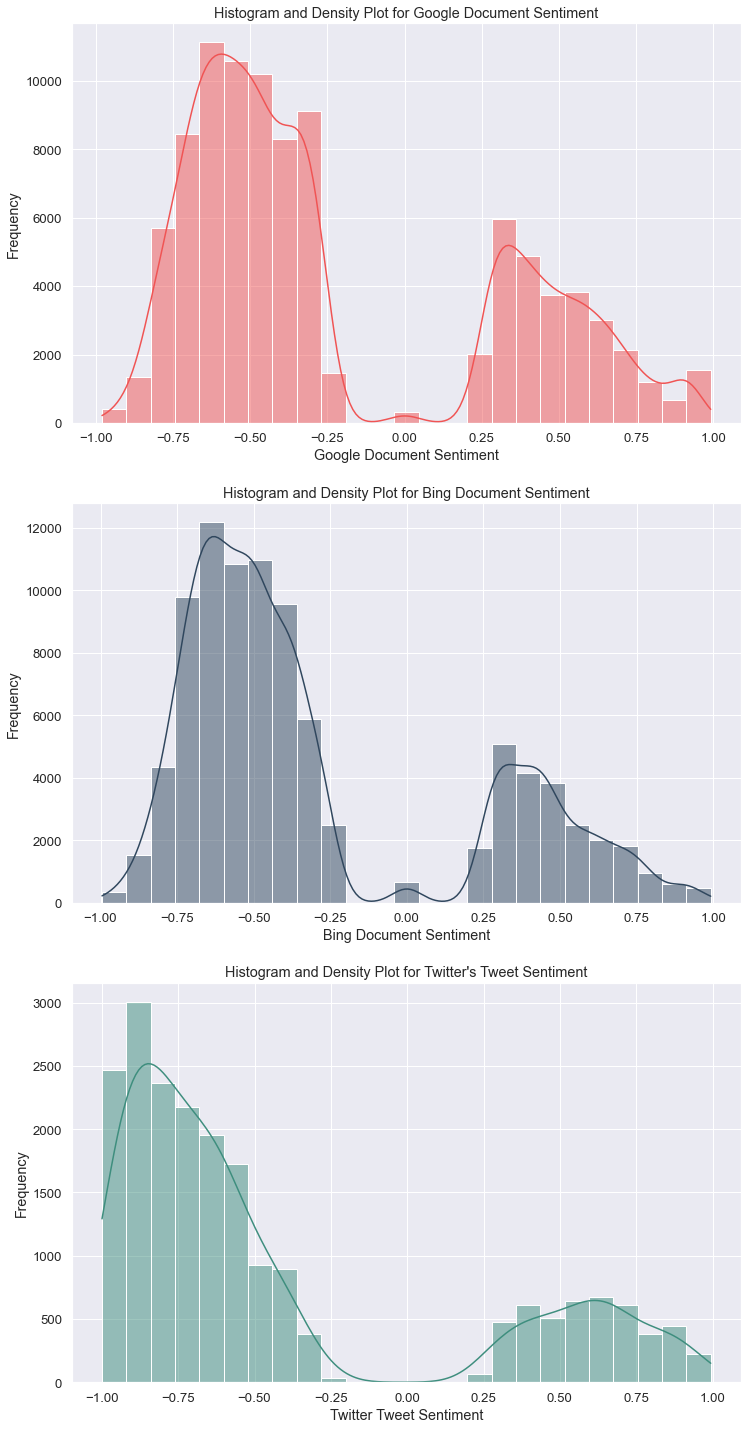

In [26]:
sentiment_plot, (google_sentiment_plot, bing_sentiment_plot, twitter_sentiment_plot) = plt.subplots(3, figsize = (12, 25))
sns.histplot(
            sentiment_google*67,
            kde = True,
            bins = 25,
            color = '#F05454',
            ax = google_sentiment_plot
        )
sns.histplot(
    sentiment_bing*67,
    kde = True,
    bins = 25,
    color = '#30475E',
    ax = bing_sentiment_plot
)

sns.histplot(
    sentiment_twitter*32,
    kde = True,
    bins = 25,
    color = '#3E8E7E',
    ax = twitter_sentiment_plot
)

plt.subplots_adjust(
    hspace = 0.2,
)

google_sentiment_plot.set(
    xlabel = "Google Document Sentiment",
    ylabel = "Frequency",
    title = "Histogram and Density Plot for Google Document Sentiment"
)

bing_sentiment_plot.set(
    xlabel = "Bing Document Sentiment",
    ylabel = "Frequency",
    title = "Histogram and Density Plot for Bing Document Sentiment",
)

twitter_sentiment_plot.set(
    xlabel = "Twitter Tweet Sentiment",
    ylabel = "Frequency",
    title = "Histogram and Density Plot for Twitter's Tweet Sentiment",
)

plt.show()

### Sentiment for International Topics Sentiment
Scatter plot demonstrating the sentiment for Twitter and the Search Engines for the international topics.

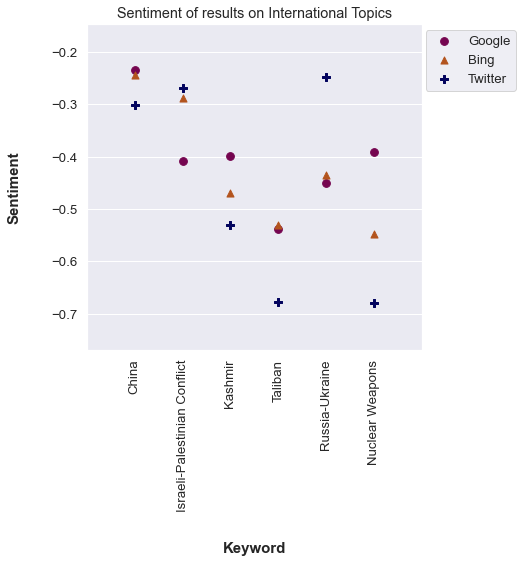

In [27]:
# Scatter Plot for the International Topics Sentiment
google_intl_kws, google_intl_sent = get_kw_issues_avg_sentiment('google', 'international')
bing_intl_kws, bing_intl_sent = get_kw_issues_avg_sentiment('bing', 'international')
twitter_intl_kws, twitter_intl_sent = get_kw_issues_avg_sentiment('twitter', 'international')

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

# For Google
ax.scatter(
    np.arange(len(google_intl_kws)), 
    google_intl_sent, 
    s = 60, marker='o', label = "Google", color = "#750550")

# For Bing
ax.scatter(
    np.arange(len(bing_intl_kws)), 
    bing_intl_sent, 
    s = 50, marker='^', label = "Bing", color = "#B3541E")

# For Twitter
ax.scatter(
    np.arange(len(twitter_intl_kws)), 
    twitter_intl_sent, 
    s = 60, marker='P', label = "Twitter", color = '#03045E')

# Parameters for the graph.
ax.xaxis.set_ticks(np.arange(len(google_intl_kws)))
ax.xaxis.set_ticklabels(google_intl_kws, rotation=90)
ax.legend(bbox_to_anchor=(1.3, 1))


plt.xlabel("Keyword", labelpad = 30, fontsize = 15, fontweight = 600)
plt.ylabel("Sentiment", labelpad = 30, fontsize = 15, fontweight = 600)
plt.grid(lw = 1, ls = '-', axis = 'x', color = '#C1A3A3')
plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})
plt.title("Sentiment of results on International Topics")
plt.margins(0.2)

plt.show()

### Sentiment for Social Topics Sentiment
Scatter plot demonstrating the sentiment for Twitter and the Search Engines for the social topics.

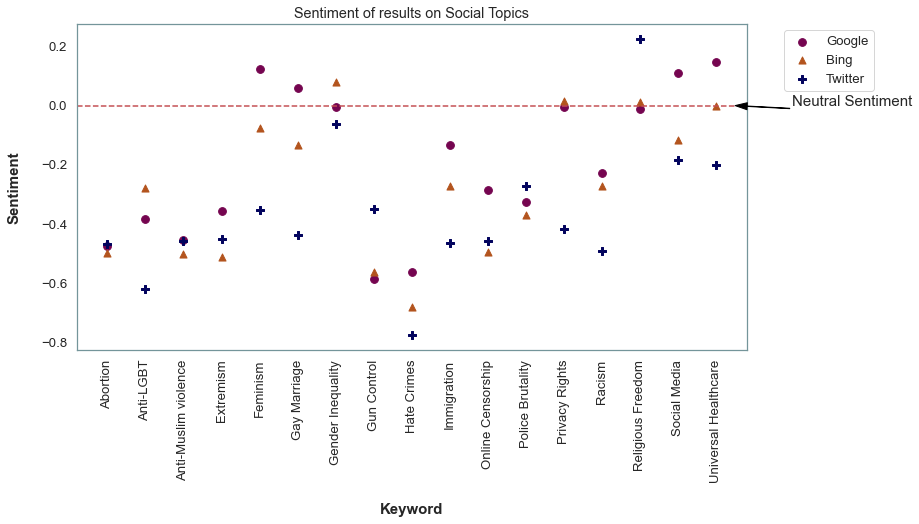

In [28]:
# Scatter Plot for the Social Topics Sentiment
google_social_kws, google_social_sent = get_kw_issues_avg_sentiment('google', 'social')
bing_social_kws, bing_social_sent = get_kw_issues_avg_sentiment('bing', 'social')
twitter_social_kws, twitter_social_sent = get_kw_issues_avg_sentiment('twitter', 'social')

fig = plt.figure(figsize=(12, 6))
ax = fig.subplots()

# For Google
ax.scatter(
    np.arange(len(google_social_kws)), 
    google_social_sent, 
    s = 60, marker='o', label = "Google", color = "#750550")

# For Bing
ax.scatter(
    np.arange(len(bing_social_kws)), 
    bing_social_sent, 
    s = 50, marker='^', label = "Bing", color = "#B3541E")

# For Twitter
ax.scatter(
    np.arange(len(twitter_social_kws)), 
    twitter_social_sent, 
    s = 60, marker='P', label = "Twitter", color = '#03045E')

# Parameters for the graph.
ax.xaxis.set_ticks(np.arange(len(google_social_kws)))
ax.xaxis.set_ticklabels(google_social_kws, rotation=90)
ax.legend(bbox_to_anchor=(1.2, 1))

plt.axhline(y=0, color='r', linestyle='--')
plt.annotate('Neutral Sentiment', xy=(16.5, 0), xytext=(18, 0), fontsize=15, arrowprops={'width':0.4,'headwidth':7,'color':'black'})

plt.xlabel("Keyword", labelpad = 20, fontsize = 15, fontweight = 600)
plt.ylabel("Sentiment", labelpad = 20, fontsize = 15, fontweight = 600)
plt.grid(lw = 1, ls = '-', axis = 'x', color = '#C1A3A3')
plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})
plt.title("Sentiment of results on Social Topics")

plt.show()

### Sentiment for Scientific Topics Sentiment
Scatter plot demonstrating the sentiment for Twitter and the Search Engines for the scientific topics.

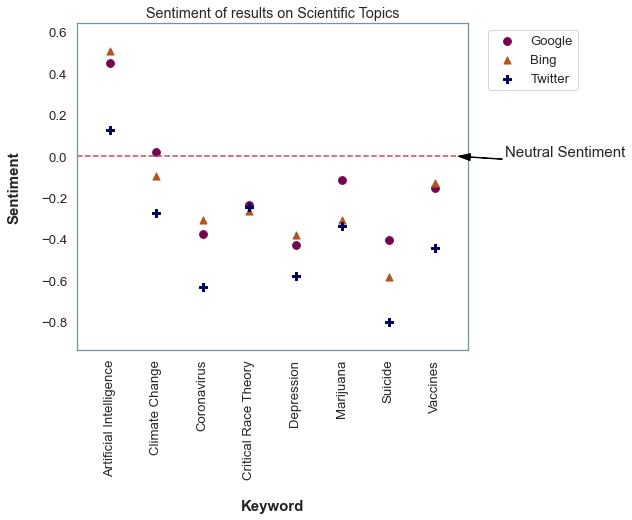

In [29]:
# Scatter Plot for the Scientific Topics Sentiment
google_science_kws, google_science_sent = get_kw_issues_avg_sentiment('google', 'scientific')
bing_science_kws, bing_science_sent = get_kw_issues_avg_sentiment('bing', 'scientific')
twitter_science_kws, twitter_science_sent = get_kw_issues_avg_sentiment('twitter', 'scientific')

fig = plt.figure(figsize=(7, 6))
ax = fig.subplots()

# For Google
ax.scatter(
    np.arange(len(google_science_kws)), 
    google_science_sent, 
    s = 60, marker='o', label = "Google", color = "#750550")

# For Bing
ax.scatter(
    np.arange(len(bing_science_kws)), 
    bing_science_sent, 
    s = 50, marker='^', label = "Bing", color = "#B3541E")

# For Twitter
ax.scatter(
    np.arange(len(twitter_science_kws)), 
    twitter_science_sent, 
    s = 60, marker='P', label = "Twitter", color = '#03045E')

# Parameters for the graph.
ax.xaxis.set_ticks(np.arange(len(google_science_kws)))
ax.xaxis.set_ticklabels(google_science_kws, rotation=90)
ax.legend(bbox_to_anchor=(1.3, 1))

plt.axhline(y=0, color='r', linestyle='--')
plt.annotate('Neutral Sentiment', xy=(7.5, 0), xytext=(8.5, 0), fontsize=15, arrowprops={'width':0.4,'headwidth':7,'color':'black'})

plt.xlabel("Keyword", labelpad = 20, fontsize = 15, fontweight = 600)
plt.ylabel("Sentiment", labelpad = 20, fontsize = 15, fontweight = 600)
plt.grid(lw = 1, ls = '-', axis = 'x', color = '#C1A3A3')
plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})
plt.title("Sentiment of results on Scientific Topics")
plt.margins(0.1)

plt.show()

In [30]:
statistics.median(twitter_science_sent)

-0.3896521443965517

### Data Frames for the sentiment across the three issue topics.

In [31]:
# Sentiment for international Issues of the search engines and Twitter.
intl_sentiment_df = pd.DataFrame(
    {"Google": google_intl_sent,
    "Bing": bing_intl_sent,
    "Twitter": twitter_intl_sent},
    index = google_intl_kws
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Sentiment on International Topics')

# Sentiment for social Issues of the search engines and Twitter.
social_sentiment_df = pd.DataFrame(
    {"Google": google_social_sent,
    "Bing": bing_social_sent,
    "Twitter": twitter_social_sent},
    index = google_social_kws
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Sentiment on Social Topics')

# Sentiment for scientific Issues of the search engines and Twitter.
science_sentiment_df = pd.DataFrame(
    {"Google": google_science_sent,
    "Bing": bing_science_sent,
    "Twitter": twitter_science_sent},
    index = google_science_kws
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Sentiment on Scientific Topics')

In [32]:
intl_sentiment_df

,Google,Bing,Twitter
China,-0.235000,-0.244000,-0.301000
Israeli-Palestinian Conflict,-0.408000,-0.287000,-0.269000
Kashmir,-0.398000,-0.470000,-0.530000
Taliban,-0.539000,-0.530000,-0.677000
Russia-Ukraine,-0.451000,-0.435000,-0.247000
Nuclear Weapons,-0.391000,-0.548000,-0.680000


In [33]:
social_sentiment_df

,Google,Bing,Twitter
Abortion,-0.475000,-0.499000,-0.469000
Anti-LGBT,-0.383000,-0.279000,-0.623000
Anti-Muslim violence,-0.454000,-0.502000,-0.459000
Extremism,-0.356000,-0.512000,-0.450000
Feminism,0.124000,-0.077000,-0.354000
Gay Marriage,0.060000,-0.132000,-0.440000
Gender Inequality,-0.003000,0.081000,-0.063000
Gun Control,-0.585000,-0.562000,-0.350000
Hate Crimes,-0.562000,-0.682000,-0.777000
Immigration,-0.134000,-0.271000,-0.464000


In [34]:
science_sentiment_df

,Google,Bing,Twitter
Artificial Intelligence,0.448000,0.510000,0.127000
Climate Change,0.022000,-0.096000,-0.275000
Coronavirus,-0.376000,-0.305000,-0.630000
Critical Race Theory,-0.233000,-0.264000,-0.243000
Depression,-0.428000,-0.379000,-0.580000
Marijuana,-0.114000,-0.308000,-0.336000
Suicide,-0.403000,-0.581000,-0.802000
Vaccines,-0.151000,-0.129000,-0.444000


### Histogram for the emotions of the search engines and Twitter

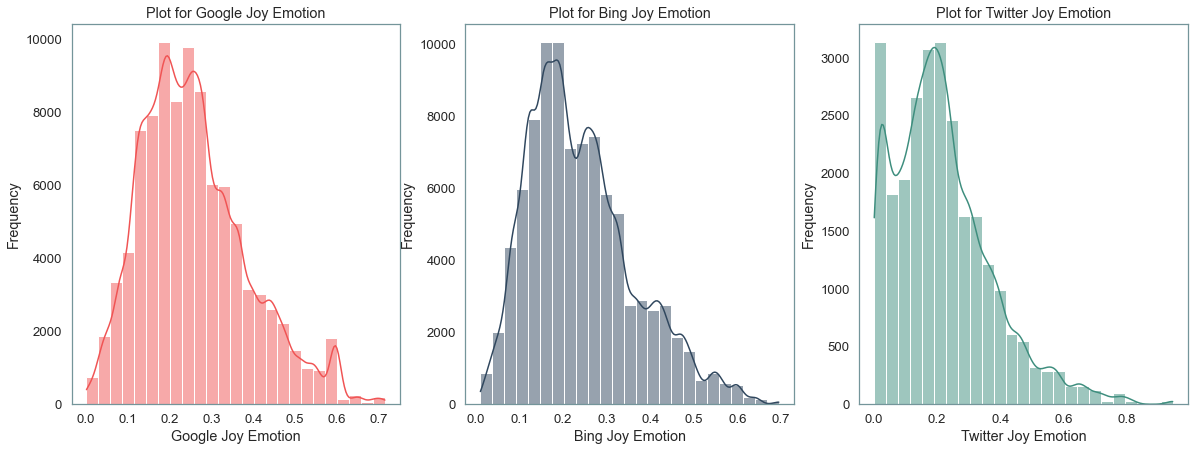

In [35]:
joy_emotion_plot, (google_joy_emotion_plot, bing_joy_emotion_plot, twitter_joy_emotion_plot) = plt.subplots(1, 3, figsize = (20, 7))
sns.histplot(
            joy_google*67,
            kde = True,
            bins = 25,
            color = '#F05454',
            ax = google_joy_emotion_plot
        )

sns.histplot(
    joy_bing*67,
    kde = True,
    bins = 25,
    color = '#30475E',
    ax = bing_joy_emotion_plot
)

sns.histplot(
    joy_twitter*32,
    kde = True,
    bins = 25,
    color = '#3E8E7E',
    ax = twitter_joy_emotion_plot
)

google_joy_emotion_plot.set(
    xlabel = "Google Joy Emotion",
    ylabel = "Frequency",
    title = "Plot for Google Joy Emotion"
)

bing_joy_emotion_plot.set(
    xlabel = "Bing Joy Emotion",
    ylabel = "Frequency",
    title = "Plot for Bing Joy Emotion",
)

twitter_joy_emotion_plot.set(
    xlabel = "Twitter Joy Emotion",
    ylabel = "Frequency",
    title = "Plot for Twitter Joy Emotion",
)

plt.show()

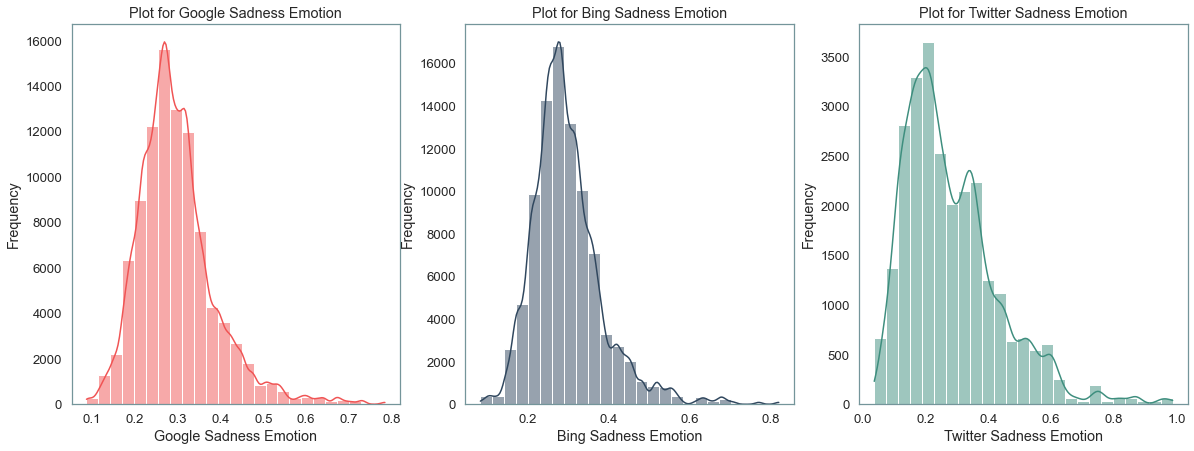

In [36]:
sadness_emotion_plot, (google_sadness_emotion_plot, bing_sadness_emotion_plot, twitter_sadness_emotion_plot) = plt.subplots(1, 3, figsize = (20, 7))
sns.histplot(
            sadness_google*67,
            kde = True,
            bins = 25,
            color = '#F05454',
            ax = google_sadness_emotion_plot
        )

sns.histplot(
    sadness_bing*67,
    kde = True,
    bins = 25,
    color = '#30475E',
    ax = bing_sadness_emotion_plot
)

sns.histplot(
    sadness_twitter*32,
    kde = True,
    bins = 25,
    color = '#3E8E7E',
    ax = twitter_sadness_emotion_plot
)

google_sadness_emotion_plot.set(
    xlabel = "Google Sadness Emotion",
    ylabel = "Frequency",
    title = "Plot for Google Sadness Emotion"
)

bing_sadness_emotion_plot.set(
    xlabel = "Bing Sadness Emotion",
    ylabel = "Frequency",
    title = "Plot for Bing Sadness Emotion",
)

twitter_sadness_emotion_plot.set(
    xlabel = "Twitter Sadness Emotion",
    ylabel = "Frequency",
    title = "Plot for Twitter Sadness Emotion",
)

plt.show()

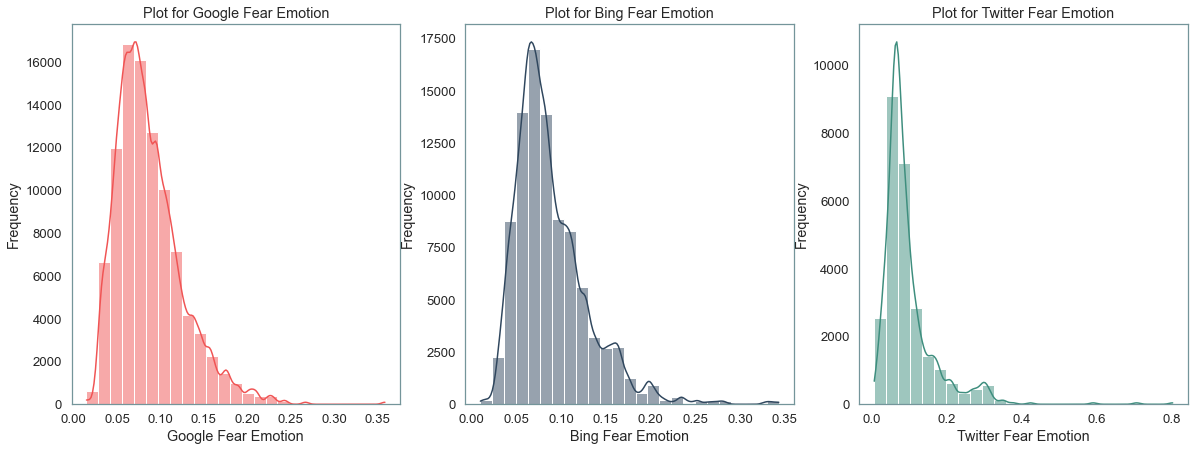

In [37]:
fear_emotion_plot, (google_fear_emotion_plot, bing_fear_emotion_plot, twitter_fear_emotion_plot) = plt.subplots(1, 3, figsize = (20, 7))
sns.histplot(
            fear_google*67,
            kde = True,
            bins = 25,
            color = '#F05454',
            ax = google_fear_emotion_plot
        )

sns.histplot(
    fear_bing*67,
    kde = True,
    bins = 25,
    color = '#30475E',
    ax = bing_fear_emotion_plot
)

sns.histplot(
    fear_twitter*32,
    kde = True,
    bins = 25,
    color = '#3E8E7E',
    ax = twitter_fear_emotion_plot
)

google_fear_emotion_plot.set(
    xlabel = "Google Fear Emotion",
    ylabel = "Frequency",
    title = "Plot for Google Fear Emotion"
)

bing_fear_emotion_plot.set(
    xlabel = "Bing Fear Emotion",
    ylabel = "Frequency",
    title = "Plot for Bing Fear Emotion",
)

twitter_fear_emotion_plot.set(
    xlabel = "Twitter Fear Emotion",
    ylabel = "Frequency",
    title = "Plot for Twitter Fear Emotion",
)

plt.show()

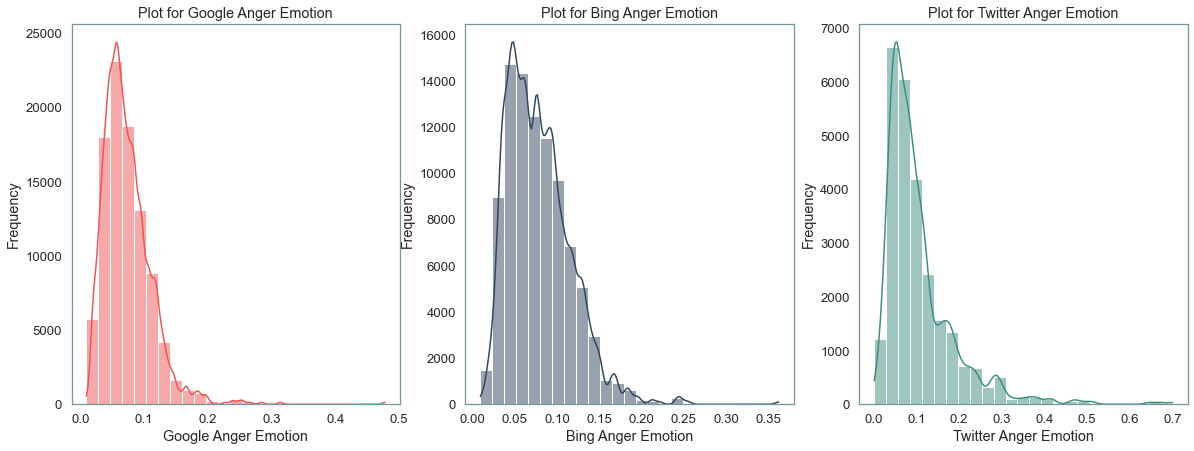

In [38]:
anger_emotion_plot, (google_anger_emotion_plot, bing_anger_emotion_plot, twitter_anger_emotion_plot) = plt.subplots(1, 3, figsize = (20, 7))
sns.histplot(
            anger_google*67,
            kde = True,
            bins = 25,
            color = '#F05454',
            ax = google_anger_emotion_plot
        )

sns.histplot(
    anger_bing*67,
    kde = True,
    bins = 25,
    color = '#30475E',
    ax = bing_anger_emotion_plot
)

sns.histplot(
    anger_twitter*32,
    kde = True,
    bins = 25,
    color = '#3E8E7E',
    ax = twitter_anger_emotion_plot
)

google_anger_emotion_plot.set(
    xlabel = "Google Anger Emotion",
    ylabel = "Frequency",
    title = "Plot for Google Anger Emotion"
)

bing_anger_emotion_plot.set(
    xlabel = "Bing Anger Emotion",
    ylabel = "Frequency",
    title = "Plot for Bing Anger Emotion",
)

twitter_anger_emotion_plot.set(
    xlabel = "Twitter Anger Emotion",
    ylabel = "Frequency",
    title = "Plot for Twitter Anger Emotion",
)

plt.show()

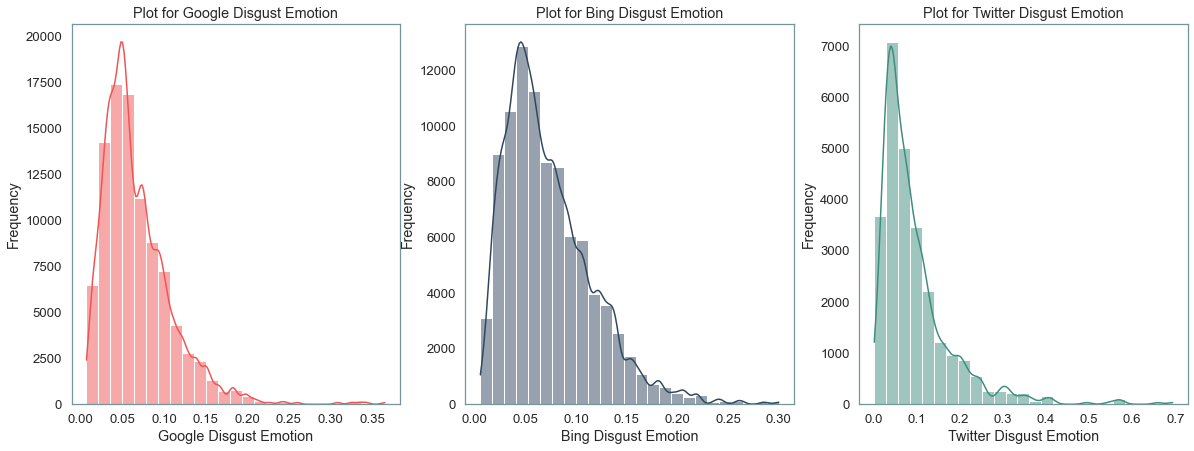

In [39]:
disgust_emotion_plot, (google_disgust_emotion_plot, bing_disgust_emotion_plot, twitter_disgust_emotion_plot) = plt.subplots(1, 3, figsize = (20, 7))
sns.histplot(
            disgust_google*67,
            kde = True,
            bins = 25,
            color = '#F05454',
            ax = google_disgust_emotion_plot
        )

sns.histplot(
    disgust_bing*67,
    kde = True,
    bins = 25,
    color = '#30475E',
    ax = bing_disgust_emotion_plot
)

sns.histplot(
    disgust_twitter*32,
    kde = True,
    bins = 25,
    color = '#3E8E7E',
    ax = twitter_disgust_emotion_plot
)

google_disgust_emotion_plot.set(
    xlabel = "Google Disgust Emotion",
    ylabel = "Frequency",
    title = "Plot for Google Disgust Emotion"
)

bing_disgust_emotion_plot.set(
    xlabel = "Bing Disgust Emotion",
    ylabel = "Frequency",
    title = "Plot for Bing Disgust Emotion",
)

twitter_disgust_emotion_plot.set(
    xlabel = "Twitter Disgust Emotion",
    ylabel = "Frequency",
    title = "Plot for Twitter Disgust Emotion",
)

plt.show()

### Box Plot for the average document sentiment of the search engines and Twitter.

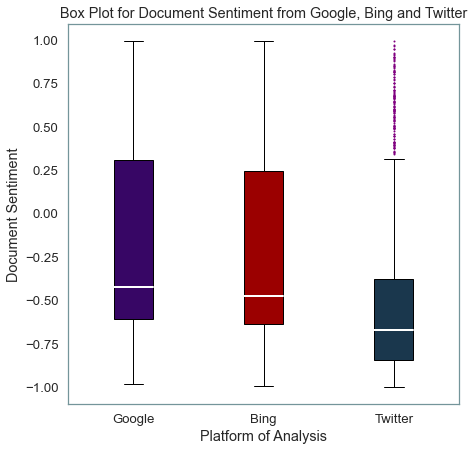

In [40]:
sentiment_box_plot = plt.figure(figsize = (7, 7))
box_plot_news_sentiment = sentiment_box_plot.subplots()


bplot1 = box_plot_news_sentiment.boxplot(
    [sentiment_google, sentiment_bing, sentiment_twitter],
    labels = ['Google', 'Bing', 'Twitter'],
    patch_artist=True
)
box_plot_news_sentiment.set(
    xlabel = "Platform of Analysis",
    ylabel = "Document Sentiment"
)
for patch, color in zip(bplot1['boxes'], ['#370665', '#9B0000', '#1A374D']):
    patch.set(
        facecolor = color,
    )
for element in bplot1['medians']:
    element.set(
        color = 'white',
        linewidth = 2
    )
    
for element in bplot1['fliers']:
    element.set(
        markerfacecolor='purple',
        linewidth = 2,
        markeredgecolor='none',
        markersize=2
    )
    
plt.title("Box Plot for Document Sentiment from Google, Bing and Twitter")
plt.show()

### Emotion Data Frames for the search engines and Twitter.

In [41]:
# Get the joy emotion for the issues.
int_issue_list_google, google_intl_emot_joy = get_kw_issues_avg_emotion('google', 'international', 'joy')
int_issue_list_bing, bing_intl_emot_joy = get_kw_issues_avg_emotion('bing', 'international', 'joy')
int_issue_list_twitter, twitter_intl_emot_joy = get_kw_issues_avg_emotion('twitter', 'international', 'joy')
social_issue_list_google, google_social_emot_joy = get_kw_issues_avg_emotion('google', 'social', 'joy')
social_issue_list_bing, bing_social_emot_joy = get_kw_issues_avg_emotion('bing', 'social', 'joy')
social_issue_list_twitter, twitter_social_emot_joy = get_kw_issues_avg_emotion('twitter', 'social', 'joy')
science_issue_list_google, google_science_emot_joy = get_kw_issues_avg_emotion('google', 'scientific', 'joy')
science_issue_list_bing, bing_science_emot_joy = get_kw_issues_avg_emotion('bing', 'scientific', 'joy')
science_issue_list_twitter, twitter_science_emot_joy = get_kw_issues_avg_emotion('twitter', 'scientific', 'joy')


intl_emotion_joy_df = pd.DataFrame(
    {"Google": google_intl_emot_joy,
    "Bing": bing_intl_emot_joy,
    "Twitter": twitter_intl_emot_joy},
    index = int_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Joy Emotion on International Topics')

social_emotion_joy_df = pd.DataFrame(
    {"Google": google_social_emot_joy,
    "Bing": bing_social_emot_joy,
    "Twitter": twitter_social_emot_joy},
    index = social_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Joy Emotion on Social Topics')

science_emotion_joy_df = pd.DataFrame(
    {"Google": google_science_emot_joy,
    "Bing": bing_science_emot_joy,
    "Twitter": twitter_science_emot_joy},
    index = science_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Joy Emotion on Scientific Topics')

intl_emotion_joy_df_no_twitter = pd.DataFrame(
    {"Google": google_intl_emot_joy,
    "Bing": bing_intl_emot_joy},
    index = int_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Joy Emotion on International Topics')

social_emotion_joy_df_no_twitter = pd.DataFrame(
    {"Google": google_social_emot_joy,
    "Bing": bing_social_emot_joy},
    index = social_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Joy Emotion on Social Topics')

science_emotion_joy_df_no_twitter = pd.DataFrame(
    {"Google": google_science_emot_joy,
    "Bing": bing_science_emot_joy},
    index = science_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Joy Emotion on Scientific Topics')

In [42]:
display(intl_emotion_joy_df)
display(social_emotion_joy_df)
display(science_emotion_joy_df)

,Google,Bing,Twitter
China,0.268000,0.255000,0.229000
Israeli-Palestinian Conflict,0.221000,0.216000,0.246000
Kashmir,0.283000,0.232000,0.287000
Taliban,0.223000,0.233000,0.210000
Russia-Ukraine,0.181000,0.168000,0.246000
Nuclear Weapons,0.211000,0.182000,0.119000


,Google,Bing,Twitter
Abortion,0.172000,0.152000,0.186000
Anti-LGBT,0.219000,0.235000,0.126000
Anti-Muslim violence,0.205000,0.187000,0.213000
Extremism,0.211000,0.180000,0.224000
Feminism,0.385000,0.325000,0.272000
Gay Marriage,0.281000,0.240000,0.223000
Gender Inequality,0.347000,0.371000,0.278000
Gun Control,0.166000,0.149000,0.154000
Hate Crimes,0.165000,0.133000,0.158000
Immigration,0.225000,0.191000,0.172000


,Google,Bing,Twitter
Artificial Intelligence,0.418000,0.423000,0.451000
Climate Change,0.374000,0.348000,0.274000
Coronavirus,0.244000,0.248000,0.166000
Critical Race Theory,0.243000,0.252000,0.216000
Depression,0.232000,0.251000,0.206000
Marijuana,0.260000,0.220000,0.232000
Suicide,0.200000,0.156000,0.151000
Vaccines,0.271000,0.288000,0.273000


In [43]:
display(intl_emotion_joy_df_no_twitter)
display(social_emotion_joy_df_no_twitter)
display(science_emotion_joy_df_no_twitter)

,Google,Bing
China,0.268000,0.255000
Israeli-Palestinian Conflict,0.221000,0.216000
Kashmir,0.283000,0.232000
Taliban,0.223000,0.233000
Russia-Ukraine,0.181000,0.168000
Nuclear Weapons,0.211000,0.182000


,Google,Bing
Abortion,0.172000,0.152000
Anti-LGBT,0.219000,0.235000
Anti-Muslim violence,0.205000,0.187000
Extremism,0.211000,0.180000
Feminism,0.385000,0.325000
Gay Marriage,0.281000,0.240000
Gender Inequality,0.347000,0.371000
Gun Control,0.166000,0.149000
Hate Crimes,0.165000,0.133000
Immigration,0.225000,0.191000


,Google,Bing
Artificial Intelligence,0.418000,0.423000
Climate Change,0.374000,0.348000
Coronavirus,0.244000,0.248000
Critical Race Theory,0.243000,0.252000
Depression,0.232000,0.251000
Marijuana,0.260000,0.220000
Suicide,0.200000,0.156000
Vaccines,0.271000,0.288000


In [44]:
int_issue_list_google, google_intl_emot_sadness = get_kw_issues_avg_emotion('google', 'international', 'sadness')
int_issue_list_bing, bing_intl_emot_sadness = get_kw_issues_avg_emotion('bing', 'international', 'sadness')
int_issue_list_twitter, twitter_intl_emot_sadness = get_kw_issues_avg_emotion('twitter', 'international', 'sadness')
social_issue_list_google, google_social_emot_sadness = get_kw_issues_avg_emotion('google', 'social', 'sadness')
social_issue_list_bing, bing_social_emot_sadness = get_kw_issues_avg_emotion('bing', 'social', 'sadness')
social_issue_list_twitter, twitter_social_emot_sadness = get_kw_issues_avg_emotion('twitter', 'social', 'sadness')
science_issue_list_google, google_science_emot_sadness = get_kw_issues_avg_emotion('google', 'scientific', 'sadness')
science_issue_list_bing, bing_science_emot_sadness = get_kw_issues_avg_emotion('bing', 'scientific', 'sadness')
science_issue_list_twitter, twitter_science_emot_sadness = get_kw_issues_avg_emotion('twitter', 'scientific', 'sadness')


intl_emotion_sadness_df = pd.DataFrame(
    {"Google": google_intl_emot_sadness,
    "Bing": bing_intl_emot_sadness,
    "Twitter": twitter_intl_emot_sadness},
    index = int_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Sadness Emotion on International Topics')

social_emotion_sadness_df = pd.DataFrame(
    {"Google": google_social_emot_sadness,
    "Bing": bing_social_emot_sadness,
    "Twitter": twitter_social_emot_sadness},
    index = social_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Sadness Emotion on Social Topics')

science_emotion_sadness_df = pd.DataFrame(
    {"Google": google_science_emot_sadness,
    "Bing": bing_science_emot_sadness,
    "Twitter": twitter_science_emot_sadness},
    index = science_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Sadness Emotion on Scientific Topics')

intl_emotion_sadness_df_no_twitter = pd.DataFrame(
    {"Google": google_intl_emot_sadness,
    "Bing": bing_intl_emot_sadness},
    index = int_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Sadness Emotion on International Topics')

social_emotion_sadness_df_no_twitter = pd.DataFrame(
    {"Google": google_social_emot_sadness,
    "Bing": bing_social_emot_sadness},
    index = social_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Sadness Emotion on Social Topics')

science_emotion_sadness_df_no_twitter = pd.DataFrame(
    {"Google": google_science_emot_sadness,
    "Bing": bing_science_emot_sadness},
    index = science_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Sadness Emotion on Scientific Topics')

In [45]:
display(intl_emotion_sadness_df)
display(social_emotion_sadness_df)
display(science_emotion_sadness_df)

,Google,Bing,Twitter
China,0.294000,0.277000,0.292000
Israeli-Palestinian Conflict,0.268000,0.280000,0.242000
Kashmir,0.317000,0.311000,0.260000
Taliban,0.334000,0.323000,0.410000
Russia-Ukraine,0.320000,0.295000,0.278000
Nuclear Weapons,0.257000,0.269000,0.289000


,Google,Bing,Twitter
Abortion,0.305000,0.324000,0.330000
Anti-LGBT,0.306000,0.295000,0.351000
Anti-Muslim violence,0.278000,0.286000,0.287000
Extremism,0.293000,0.280000,0.286000
Feminism,0.243000,0.254000,0.195000
Gay Marriage,0.288000,0.263000,0.230000
Gender Inequality,0.286000,0.295000,0.309000
Gun Control,0.255000,0.269000,0.208000
Hate Crimes,0.269000,0.255000,0.189000
Immigration,0.300000,0.283000,0.245000


,Google,Bing,Twitter
Artificial Intelligence,0.245000,0.239000,0.190000
Climate Change,0.237000,0.246000,0.186000
Coronavirus,0.341000,0.328000,0.252000
Critical Race Theory,0.274000,0.265000,0.238000
Depression,0.486000,0.464000,0.576000
Marijuana,0.301000,0.285000,0.263000
Suicide,0.398000,0.406000,0.397000
Vaccines,0.339000,0.330000,0.324000


In [46]:
display(intl_emotion_sadness_df_no_twitter)
display(social_emotion_sadness_df_no_twitter)
display(science_emotion_sadness_df_no_twitter)

,Google,Bing
China,0.294000,0.277000
Israeli-Palestinian Conflict,0.268000,0.280000
Kashmir,0.317000,0.311000
Taliban,0.334000,0.323000
Russia-Ukraine,0.320000,0.295000
Nuclear Weapons,0.257000,0.269000


,Google,Bing
Abortion,0.305000,0.324000
Anti-LGBT,0.306000,0.295000
Anti-Muslim violence,0.278000,0.286000
Extremism,0.293000,0.280000
Feminism,0.243000,0.254000
Gay Marriage,0.288000,0.263000
Gender Inequality,0.286000,0.295000
Gun Control,0.255000,0.269000
Hate Crimes,0.269000,0.255000
Immigration,0.300000,0.283000


,Google,Bing
Artificial Intelligence,0.245000,0.239000
Climate Change,0.237000,0.246000
Coronavirus,0.341000,0.328000
Critical Race Theory,0.274000,0.265000
Depression,0.486000,0.464000
Marijuana,0.301000,0.285000
Suicide,0.398000,0.406000
Vaccines,0.339000,0.330000


In [47]:
int_issue_list_google, google_intl_emot_fear = get_kw_issues_avg_emotion('google', 'international', 'fear')
int_issue_list_bing, bing_intl_emot_fear = get_kw_issues_avg_emotion('bing', 'international', 'fear')
int_issue_list_twitter, twitter_intl_emot_fear = get_kw_issues_avg_emotion('twitter', 'international', 'fear')
social_issue_list_google, google_social_emot_fear = get_kw_issues_avg_emotion('google', 'social', 'fear')
social_issue_list_bing, bing_social_emot_fear = get_kw_issues_avg_emotion('bing', 'social', 'fear')
social_issue_list_twitter, twitter_social_emot_fear = get_kw_issues_avg_emotion('twitter', 'social', 'fear')
science_issue_list_google, google_science_emot_fear = get_kw_issues_avg_emotion('google', 'scientific', 'fear')
science_issue_list_bing, bing_science_emot_fear = get_kw_issues_avg_emotion('bing', 'scientific', 'fear')
science_issue_list_twitter, twitter_science_emot_fear = get_kw_issues_avg_emotion('twitter', 'scientific', 'fear')


intl_emotion_fear_df = pd.DataFrame(
    {"Google": google_intl_emot_fear,
    "Bing": bing_intl_emot_fear,
    "Twitter": twitter_intl_emot_fear},
    index = int_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Fear Emotion on International Topics')

social_emotion_fear_df = pd.DataFrame(
    {"Google": google_social_emot_fear,
    "Bing": bing_social_emot_fear,
    "Twitter": twitter_social_emot_fear},
    index = social_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Fear Emotion on Social Topics')

science_emotion_fear_df = pd.DataFrame(
    {"Google": google_science_emot_fear,
    "Bing": bing_science_emot_fear,
    "Twitter": twitter_science_emot_fear},
    index = science_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Fear Emotion on Scientific Topics')

intl_emotion_fear_df_no_twitter = pd.DataFrame(
    {"Google": google_intl_emot_fear,
    "Bing": bing_intl_emot_fear},
    index = int_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Fear Emotion on International Topics')

social_emotion_fear_df_no_twitter = pd.DataFrame(
    {"Google": google_social_emot_fear,
    "Bing": bing_social_emot_fear},
    index = social_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_max(color = '#EBEBEB', axis = 1).set_caption('Fear Emotion on Social Topics')

science_emotion_fear_df_no_twitter = pd.DataFrame(
    {"Google": google_science_emot_fear,
    "Bing": bing_science_emot_fear},
    index = science_issue_list_google
).round(3).style.set_properties(padding = "10px").highlight_min(color = '#EBEBEB', axis = 1).set_caption('Fear Emotion on Scientific Topics')

In [48]:
display(intl_emotion_fear_df)
display(social_emotion_fear_df)
display(science_emotion_fear_df)

,Google,Bing,Twitter
China,0.085000,0.094000,0.097000
Israeli-Palestinian Conflict,0.096000,0.091000,0.110000
Kashmir,0.079000,0.106000,0.082000
Taliban,0.106000,0.101000,0.100000
Russia-Ukraine,0.124000,0.127000,0.093000
Nuclear Weapons,0.155000,0.161000,0.178000


,Google,Bing,Twitter
Abortion,0.076000,0.071000,0.072000
Anti-LGBT,0.071000,0.063000,0.073000
Anti-Muslim violence,0.075000,0.077000,0.071000
Extremism,0.091000,0.097000,0.104000
Feminism,0.069000,0.085000,0.076000
Gay Marriage,0.062000,0.057000,0.076000
Gender Inequality,0.062000,0.062000,0.064000
Gun Control,0.105000,0.101000,0.119000
Hate Crimes,0.078000,0.071000,0.070000
Immigration,0.067000,0.070000,0.099000


,Google,Bing,Twitter
Artificial Intelligence,0.083000,0.088000,0.099000
Climate Change,0.109000,0.110000,0.182000
Coronavirus,0.105000,0.107000,0.123000
Critical Race Theory,0.067000,0.072000,0.090000
Depression,0.109000,0.103000,0.120000
Marijuana,0.071000,0.080000,0.069000
Suicide,0.094000,0.096000,0.097000
Vaccines,0.103000,0.106000,0.115000


In [49]:
display(intl_emotion_fear_df_no_twitter)
display(social_emotion_fear_df_no_twitter)
display(science_emotion_fear_df_no_twitter)

,Google,Bing
China,0.085000,0.094000
Israeli-Palestinian Conflict,0.096000,0.091000
Kashmir,0.079000,0.106000
Taliban,0.106000,0.101000
Russia-Ukraine,0.124000,0.127000
Nuclear Weapons,0.155000,0.161000


,Google,Bing
Abortion,0.076000,0.071000
Anti-LGBT,0.071000,0.063000
Anti-Muslim violence,0.075000,0.077000
Extremism,0.091000,0.097000
Feminism,0.069000,0.085000
Gay Marriage,0.062000,0.057000
Gender Inequality,0.062000,0.062000
Gun Control,0.105000,0.101000
Hate Crimes,0.078000,0.071000
Immigration,0.067000,0.070000


,Google,Bing
Artificial Intelligence,0.083000,0.088000
Climate Change,0.109000,0.110000
Coronavirus,0.105000,0.107000
Critical Race Theory,0.067000,0.072000
Depression,0.109000,0.103000
Marijuana,0.071000,0.080000
Suicide,0.094000,0.096000
Vaccines,0.103000,0.106000


### Average sentiment and Emotions across the issue topics for the search engines and twitter.

In [50]:
sentiment_social_google = get_kw_issues_avg_sentiment('google', 'social')
sentiment_social_bing = get_kw_issues_avg_sentiment('bing', 'social')
sentiment_social_twitter = get_kw_issues_avg_sentiment('twitter', 'social')
sentiment_intl_google = get_kw_issues_avg_sentiment('google', 'international')
sentiment_intl_bing = get_kw_issues_avg_sentiment('bing', 'international')
sentiment_intl_twitter = get_kw_issues_avg_sentiment('twitter', 'international')
sentiment_science_google = get_kw_issues_avg_sentiment('google', 'scientific')
sentiment_science_bing = get_kw_issues_avg_sentiment('bing', 'scientific')
sentiment_science_twitter = get_kw_issues_avg_sentiment('twitter', 'scientific')
sentiment_overall_google = statistics.mean(sentiment_social_google[1] + sentiment_intl_google[1] + sentiment_science_google[1])
sentiment_overall_bing = statistics.mean(sentiment_social_bing[1] + sentiment_intl_bing[1] + sentiment_science_bing[1])
sentiment_overall_twitter = statistics.mean(sentiment_social_twitter[1] + sentiment_intl_twitter[1] + sentiment_science_twitter[1])

In [51]:
df_sentiment = pd.DataFrame({
    'Social': [statistics.mean(sentiment_social_google[1]), statistics.mean(sentiment_social_bing[1]), statistics.mean(sentiment_social_twitter[1])],
    'International': [statistics.mean(sentiment_intl_google[1]), statistics.mean(sentiment_intl_bing[1]), statistics.mean(sentiment_intl_twitter[1])],
    'Scientific': [statistics.mean(sentiment_science_google[1]), statistics.mean(sentiment_science_bing[1]), statistics.mean(sentiment_science_twitter[1])],
    'Overall': [sentiment_overall_google, sentiment_overall_bing, sentiment_overall_twitter]
},
    index = ['Google','Bing', 'Twitter']
)

df_sentiment_print = df_sentiment.T.style.set_properties(padding = "10px").set_caption('Sentiment Table')

In [52]:
joy_social_google = get_kw_issues_avg_emotion('google', 'social', 'joy')
joy_social_bing = get_kw_issues_avg_emotion('bing', 'social', 'joy')
joy_social_twitter = get_kw_issues_avg_emotion('twitter', 'social', 'joy')
joy_intl_google = get_kw_issues_avg_emotion('google', 'international', 'joy')
joy_intl_bing = get_kw_issues_avg_emotion('bing', 'international', 'joy')
joy_intl_twitter = get_kw_issues_avg_emotion('twitter', 'international', 'joy')
joy_science_google = get_kw_issues_avg_emotion('google', 'scientific', 'joy')
joy_science_bing = get_kw_issues_avg_emotion('bing', 'scientific', 'joy')
joy_science_twitter = get_kw_issues_avg_emotion('twitter', 'scientific', 'joy')
joy_overall_google = statistics.mean(joy_social_google[1] + joy_intl_google[1] + joy_science_google[1])
joy_overall_bing = statistics.mean(joy_social_bing[1] + joy_intl_bing[1] + joy_science_bing[1])
joy_overall_twitter = statistics.mean(joy_social_twitter[1] + joy_intl_twitter[1] + joy_science_twitter[1])

In [53]:
df_joy = pd.DataFrame({
    'Social': [statistics.mean(joy_social_google[1]), statistics.mean(joy_social_bing[1]), statistics.mean(joy_social_twitter[1])],
    'International': [statistics.mean(joy_intl_google[1]), statistics.mean(joy_intl_bing[1]), statistics.mean(joy_intl_twitter[1])],
    'Scientific': [statistics.mean(joy_science_google[1]), statistics.mean(joy_science_bing[1]), statistics.mean(joy_science_twitter[1])],
    'Overall': [joy_overall_google, joy_overall_bing, joy_overall_twitter]
},
    index = ['Google','Bing', 'Twitter']
)

df_joy_print = df_joy.T.style.set_properties(padding = "10px").set_caption('Joy Emotion Table')

In [54]:
sadness_social_google = get_kw_issues_avg_emotion('google', 'social', 'sadness')
sadness_social_bing = get_kw_issues_avg_emotion('bing', 'social', 'sadness')
sadness_social_twitter = get_kw_issues_avg_emotion('twitter', 'social', 'sadness')
sadness_intl_google = get_kw_issues_avg_emotion('google', 'international', 'sadness')
sadness_intl_bing = get_kw_issues_avg_emotion('bing', 'international', 'sadness')
sadness_intl_twitter = get_kw_issues_avg_emotion('twitter', 'international', 'sadness')
sadness_science_google = get_kw_issues_avg_emotion('google', 'scientific', 'sadness')
sadness_science_bing = get_kw_issues_avg_emotion('bing', 'scientific', 'sadness')
sadness_science_twitter = get_kw_issues_avg_emotion('twitter', 'scientific', 'sadness')
sadness_overall_google = statistics.mean(sadness_social_google[1] + sadness_intl_google[1] + sadness_science_google[1])
sadness_overall_bing = statistics.mean(sadness_social_bing[1] + sadness_intl_bing[1] + sadness_science_bing[1])
sadness_overall_twitter = statistics.mean(sadness_social_twitter[1] + sadness_intl_twitter[1] + sadness_science_twitter[1])

In [55]:
df_sadness = pd.DataFrame({
    'Social': [statistics.mean(sadness_social_google[1]), statistics.mean(sadness_social_bing[1]), statistics.mean(sadness_social_twitter[1])],
    'International': [statistics.mean(sadness_intl_google[1]), statistics.mean(sadness_intl_bing[1]), statistics.mean(sadness_intl_twitter[1])],
    'Scientific': [statistics.mean(sadness_science_google[1]), statistics.mean(sadness_science_bing[1]), statistics.mean(sadness_science_twitter[1])],
    'Overall': [sadness_overall_google, sadness_overall_bing, sadness_overall_twitter]
},
    index = ['Google','Bing', 'Twitter']
)

df_sadness_print = df_sadness.T.style.set_properties(padding = "10px").set_caption('Sadness Emotion Table')

In [56]:
fear_social_google = get_kw_issues_avg_emotion('google', 'social', 'fear')
fear_social_bing = get_kw_issues_avg_emotion('bing', 'social', 'fear')
fear_social_twitter = get_kw_issues_avg_emotion('twitter', 'social', 'fear')
fear_intl_google = get_kw_issues_avg_emotion('google', 'international', 'fear')
fear_intl_bing = get_kw_issues_avg_emotion('bing', 'international', 'fear')
fear_intl_twitter = get_kw_issues_avg_emotion('twitter', 'international', 'fear')
fear_science_google = get_kw_issues_avg_emotion('google', 'scientific', 'fear')
fear_science_bing = get_kw_issues_avg_emotion('bing', 'scientific', 'fear')
fear_science_twitter = get_kw_issues_avg_emotion('twitter', 'scientific', 'fear')
fear_overall_google = statistics.mean(fear_social_google[1] + fear_intl_google[1] + fear_science_google[1])
fear_overall_bing = statistics.mean(fear_social_bing[1] + fear_intl_bing[1] + fear_science_bing[1])
fear_overall_twitter = statistics.mean(fear_social_twitter[1] + fear_intl_twitter[1] + fear_science_twitter[1])

In [57]:
df_fear = pd.DataFrame({
    'Social': [statistics.mean(fear_social_google[1]), statistics.mean(fear_social_bing[1]), statistics.mean(fear_social_twitter[1])],
    'International': [statistics.mean(fear_intl_google[1]), statistics.mean(fear_intl_bing[1]), statistics.mean(fear_intl_twitter[1])],
    'Scientific': [statistics.mean(fear_science_google[1]), statistics.mean(fear_science_bing[1]), statistics.mean(fear_science_twitter[1])],
    'Overall': [fear_overall_google, fear_overall_bing, fear_overall_twitter]
},
    index = ['Google','Bing', 'Twitter']
)

df_fear_print = df_fear.T.style.set_properties(padding = "10px").set_caption('Fear Emotion Table')

In [58]:
anger_social_google = get_kw_issues_avg_emotion('google', 'social', 'anger')
anger_social_bing = get_kw_issues_avg_emotion('bing', 'social', 'anger')
anger_social_twitter = get_kw_issues_avg_emotion('twitter', 'social', 'anger')
anger_intl_google = get_kw_issues_avg_emotion('google', 'international', 'anger')
anger_intl_bing = get_kw_issues_avg_emotion('bing', 'international', 'anger')
anger_intl_twitter = get_kw_issues_avg_emotion('twitter', 'international', 'anger')
anger_science_google = get_kw_issues_avg_emotion('google', 'scientific', 'anger')
anger_science_bing = get_kw_issues_avg_emotion('bing', 'scientific', 'anger')
anger_science_twitter = get_kw_issues_avg_emotion('twitter', 'scientific', 'anger')
anger_overall_google = statistics.mean(anger_social_google[1] + anger_intl_google[1] + anger_science_google[1])
anger_overall_bing = statistics.mean(anger_social_bing[1] + anger_intl_bing[1] + anger_science_bing[1])
anger_overall_twitter = statistics.mean(anger_social_twitter[1] + anger_intl_twitter[1] + anger_science_twitter[1])


In [59]:
df_anger = pd.DataFrame({
    'Social': [statistics.mean(anger_social_google[1]), statistics.mean(anger_social_bing[1]), statistics.mean(anger_social_twitter[1])],
    'International': [statistics.mean(anger_intl_google[1]), statistics.mean(anger_intl_bing[1]), statistics.mean(anger_intl_twitter[1])],
    'Scientific': [statistics.mean(anger_science_google[1]), statistics.mean(anger_science_bing[1]), statistics.mean(anger_science_twitter[1])],
    'Overall': [anger_overall_google, anger_overall_bing, anger_overall_twitter]
},
    index = ['Google','Bing', 'Twitter']
)

df_anger_print = df_anger.T.style.set_properties(padding = "10px").set_caption('Anger Emotion Table')

In [60]:
df_anger_print

,Google,Bing,Twitter
Social,0.081649,0.087954,0.108240
International,0.082798,0.088565,0.117268
Scientific,0.056251,0.060739,0.080983
Overall,0.075317,0.081049,0.102954


In [61]:
df_joy_print

,Google,Bing,Twitter
Social,0.255723,0.234015,0.215706
International,0.231169,0.214406,0.222791
Scientific,0.280257,0.273203,0.246208
Overall,0.257302,0.240333,0.224948


In [62]:
df_sadness_print

,Google,Bing,Twitter
Social,0.279099,0.277288,0.260134
International,0.298369,0.292433,0.295338
Scientific,0.327591,0.320413,0.303159
Overall,0.295343,0.291348,0.278051


In [63]:
df_fear_print

,Google,Bing,Twitter
Social,0.076344,0.074255,0.083879
International,0.107307,0.113649,0.109958
Scientific,0.092419,0.095387,0.111939
Overall,0.086485,0.087333,0.096168


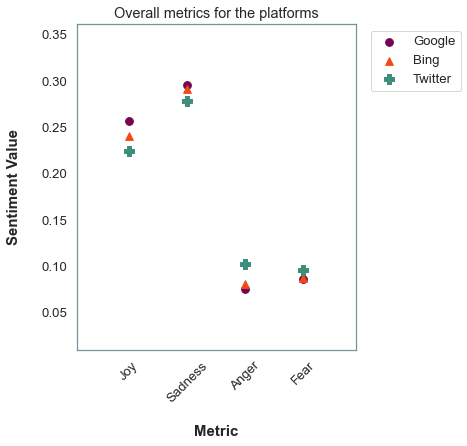

In [64]:
# Scatter Plot for the Overall emotions

fig = plt.figure(figsize=(5, 6))
ax = fig.subplots()

# For Google
ax.scatter(
    np.arange(4), 
    [df_joy['Overall']['Google'], df_sadness['Overall']['Google'], df_anger['Overall']['Google'], df_fear['Overall']['Google']],
    s = 60, marker='o', label = "Google", color = "#750550")

# For Bing
ax.scatter(
    np.arange(4), 
    [df_joy['Overall']['Bing'], df_sadness['Overall']['Bing'], df_anger['Overall']['Bing'], df_fear['Overall']['Bing']],
    s = 60, marker='^', label = "Bing", color = "#F14A16")

# For Bing
ax.scatter(
    np.arange(4), 
    [df_joy['Overall']['Twitter'], df_sadness['Overall']['Twitter'], df_anger['Overall']['Twitter'], df_fear['Overall']['Twitter']],
    s = 100, marker='P', label = "Twitter", color = "#3E8E7E")

ax.xaxis.set_ticks(np.arange(4))
ax.xaxis.set_ticklabels(['Joy', 'Sadness', 'Anger', 'Fear'], rotation=45)
ax.legend(bbox_to_anchor=(1.4, 1))

plt.xlabel("Metric", labelpad = 20, fontsize = 15, fontweight = 600)
plt.ylabel("Sentiment Value", labelpad = 20, fontsize = 15, fontweight = 600)
plt.grid(lw = 1, ls = '-', axis = 'x', color = '#C1A3A3')
plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})
plt.title("Overall metrics for the platforms")
plt.margins(0.3)

plt.show()

In [65]:
# Top Entity Analysis
def get_top_entity_from_engine(engine_name, type_entity):
    myCursor.execute(
        'select news_sentiment.entity_1_sentiment from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine_name}" and news_sentiment.entity_1_type = "{type_entity}";'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

def get_top_entity_from_twitter(type_entity):
    myCursor.execute(
        'select entity_1_sentiment from twitter_sentiment '
        f'where entity_1_type = "{type_entity}";'
    )
    return [float(i[0]) for i in myCursor.fetchall()]

In [66]:
top_entity_google_person = statistics.mean(get_top_entity_from_engine('google', 'Person'))
top_entity_bing_person = statistics.mean(get_top_entity_from_engine('bing', 'Person'))
top_entity_twitter_person = statistics.mean(get_top_entity_from_twitter('Person'))
top_entity_google_org = statistics.mean(get_top_entity_from_engine('google', 'Organization'))
top_entity_bing_org = statistics.mean(get_top_entity_from_engine('bing', 'Organization'))
top_entity_twitter_org = statistics.mean(get_top_entity_from_twitter('Organization'))
top_entity_google_loc = statistics.mean(get_top_entity_from_engine('google', 'Location'))
top_entity_bing_loc = statistics.mean(get_top_entity_from_engine('bing', 'Location'))
top_entity_twitter_loc = statistics.mean(get_top_entity_from_twitter('Location'))

In [67]:
entity_dataframe = pd.DataFrame(
    {
        'Google': [top_entity_google_person, top_entity_google_org, top_entity_google_loc],
        'Bing': [top_entity_bing_person, top_entity_bing_org, top_entity_bing_loc],
        'Twitter': [top_entity_twitter_person, top_entity_twitter_org, top_entity_twitter_loc]
    },
    index = ["Person", "Organization", "Location"]
)
entity_data_frame_print = entity_dataframe.style.set_properties(padding = "10px").set_caption("Entity and Sentiment")

In [68]:
entity_data_frame_print

,Google,Bing,Twitter
Person,-0.262240,-0.260235,-0.264330
Organization,-0.029421,-0.080661,-0.229408
Location,-0.316857,-0.298161,-0.224187


In [69]:
google_publishers_raw = get_frequency_publishers('google', 15)
bing_publishers_raw = get_frequency_publishers('bing', 15)
google_publishers_freq = []
bing_publishers_freq = []
google_publishers = []
bing_publishers = []

for publisher, freq in google_publishers_raw:
    google_publishers.append(publisher)
    google_publishers_freq.append(freq)
    
for publisher, freq in bing_publishers_raw:
    bing_publishers.append(publisher)
    bing_publishers_freq.append(freq)

In [70]:
# Cleaned data at February 25, 2022

google_publishers = [
    'The New York Times', 'Reuters', 'Al Jazeera', 'Washington Post', 'NPR', 
    'The Guardian', 'The Hill', 'CNN', 'ABC News', 'The Wire']
bing_publishers = [
    'Fox News', 'The New York Times', 'Associated Press', 'Reuters', 'The Guardian',
    'CNN', 'Forbes', 'ABC News', 'Washington Post', 'Washington Observer'
]
bing_publishers_freq = [
    3978, 3912, 3671, 2589, 2567, 1832, 1809, 1781, 1442, 1421
]
google_publishers_freq = [
    6992, 3802, 3491, 3344, 2872, 2580, 2437, 1973, 1964, 1822
]

In [71]:
top_10_publishers = pd.DataFrame({
    'Google': google_publishers,
    'Frequency (Google)': google_publishers_freq,
    'Bing': bing_publishers,
    'Frequency (Bing)': bing_publishers_freq
})
top_10_publishers_print = top_10_publishers.style.set_properties(padding = "10px").set_caption("Top 10 Publishers")

In [72]:
top_10_publishers_print

,Google,Frequency (Google),Bing,Frequency (Bing)
0,The New York Times,6992,Fox News,3978
1,Reuters,3802,The New York Times,3912
2,Al Jazeera,3491,Associated Press,3671
3,Washington Post,3344,Reuters,2589
4,NPR,2872,The Guardian,2567
5,The Guardian,2580,CNN,1832
6,The Hill,2437,Forbes,1809
7,CNN,1973,ABC News,1781
8,ABC News,1964,Washington Post,1442
9,The Wire,1822,Washington Observer,1421


In [73]:
allsides_data = pd.DataFrame(
    view_allsides_data(),
    columns = ["News", "Ratings", "Rating Number", "Percentage Agree"]
)

In [74]:
allsides_data

,News,Ratings,Rating Number,Percentage Agree
0,AARP,center,3,0.374700
1,ABC News,left-center,2,0.594475
2,Abridge News,allsides,NA,0.645833
3,Accuracy in Media,right,5,0.625948
4,ACLU,left-center,2,0.428427
...,...,...,...,...
433,William McGurn,right,5,0.681818
434,Wisconsin Gazette,left-center,2,0.529968
435,WND.com,right,5,0.711507
436,Yahoo! News,left-center,2,0.555378


In [75]:
google_ratings = [get_allsides_ratings(i) for i in google_publishers]
bing_ratings = [get_allsides_ratings(i) for i in bing_publishers]

In [76]:
comp_top_10_publishers_ratings = pd.DataFrame({
    'Google': google_publishers,
    'Frequency (Google)': google_publishers_freq,
    'Ratings (Google)': google_ratings,
    'Bing': bing_publishers,
    'Frequency (Bing)': bing_publishers_freq,
    'Ratings (Bing)': bing_ratings
})
comp_top_10_publishers_ratings_print = comp_top_10_publishers_ratings.style.set_properties(padding = "10px").set_caption("Top 10 Publishers")

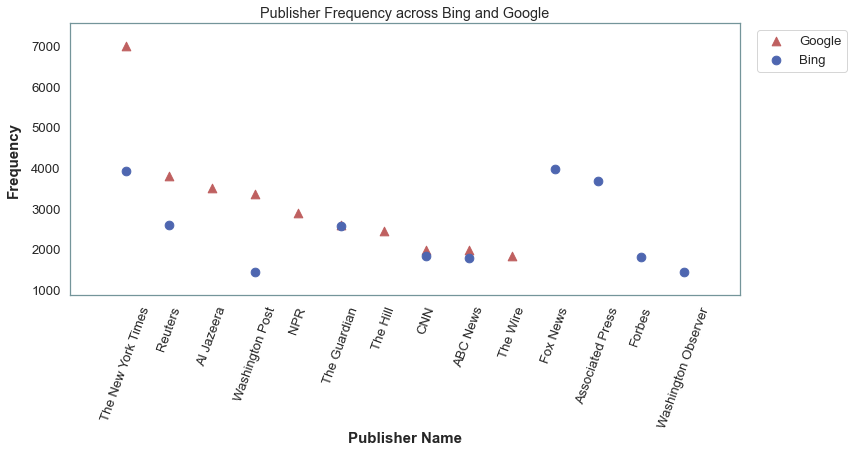

In [77]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots()

ax.scatter(
    top_10_publishers['Google'],
    top_10_publishers['Frequency (Google)'],
    s = 75,
    marker='^', 
    label = "Google",
    color = "#BF6060"
)

ax.scatter(
    top_10_publishers['Bing'],
    top_10_publishers['Frequency (Bing)'],
    s = 75,
    marker='o',
    label = "Bing",
    color = "#4E66B0"
)

plt.xlabel("Publisher Name", labelpad = 2, fontsize = 15, fontweight = 600)
plt.ylabel("Frequency", labelpad = 10, fontsize = 15, fontweight = 600)
plt.grid(lw = 1, ls = '-', axis = 'y', color = '#E9EAED')
plt.grid(lw = 1, ls = '-', axis = 'x', color = '#E9EAED')
ax.legend(bbox_to_anchor=(1.17, 1))

plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#7A89B6'})
plt.title("Publisher Frequency across Bing and Google")
plt.xticks(rotation=70)
plt.margins(0.1)

plt.show()

In [78]:
comp_top_10_publishers_ratings_print

,Google,Frequency (Google),Ratings (Google),Bing,Frequency (Bing),Ratings (Bing)
0,The New York Times,6992,left-center,Fox News,3978,right-center
1,Reuters,3802,center,The New York Times,3912,left-center
2,Al Jazeera,3491,left-center,Associated Press,3671,center
3,Washington Post,3344,left-center,Reuters,2589,center
4,NPR,2872,center,The Guardian,2567,left-center
5,The Guardian,2580,left-center,CNN,1832,left-center
6,The Hill,2437,center,Forbes,1809,center
7,CNN,1973,left-center,ABC News,1781,left-center
8,ABC News,1964,left-center,Washington Post,1442,left-center
9,The Wire,1822,left,Washington Observer,1421,right-center


In [79]:
count_publisher_leaning = pd.DataFrame(
    {
        'Google': comp_top_10_publishers_ratings['Ratings (Google)'].value_counts(),
        'Bing': comp_top_10_publishers_ratings['Ratings (Bing)'].value_counts()
    }
).fillna(0)

In [80]:
count_publisher_leaning

,Google,Bing
center,3.0,3.0
left,1.0,0.0
left-center,6.0,5.0
right-center,0.0,2.0


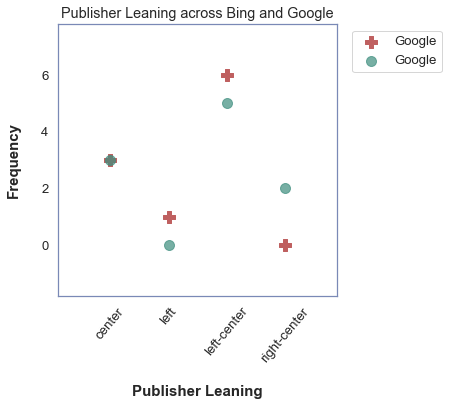

In [81]:
fig = plt.figure(figsize=(5, 5))
ax = fig.subplots()

ax.scatter(
    count_publisher_leaning.index,
    count_publisher_leaning['Google'],
    s = 150,
    marker='P', 
    label = "Google",
    color = "#BF6060",
    alpha = 1
)

ax.scatter(
    count_publisher_leaning.index,
    count_publisher_leaning['Bing'],
    s = 100,
    marker='o', 
    label = "Google",
    color = "#3E8E7E",
    alpha = 0.7
)

plt.xlabel("Publisher Leaning", labelpad = 20, fontsize = 15, fontweight = 600)
plt.ylabel("Frequency", labelpad = 20, fontsize = 15, fontweight = 600)
plt.grid(lw = 1, ls = '-', axis = 'y', color = '#E9EAED')
plt.grid(lw = 1, ls = '-', axis = 'x', color = '#E9EAED')
ax.legend(bbox_to_anchor=(1.4, 1))

plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#7A89B6'})
plt.title("Publisher Leaning across Bing and Google")
plt.xticks(rotation=50)
plt.margins(0.3)

plt.show()

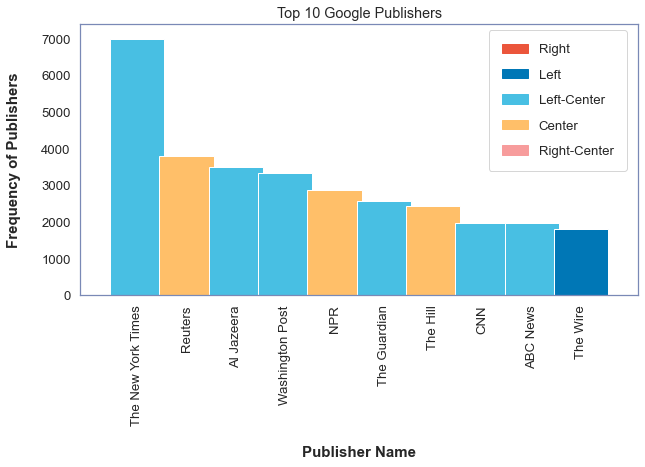

In [82]:
red_patch = mpatches.Patch(color='#eb553b', label='Right')
blue_patch = mpatches.Patch(color='#0077b6', label='Left')
pink_patch = mpatches.Patch(color='#f79c9c', label='Right-Center')
l_blue_patch = mpatches.Patch(color='#48bfe3', label='Left-Center')
green_patch = mpatches.Patch(color='#ffbf69', label='Center')

plt.figure(figsize=(10,5))
plt.xticks(rotation=70)
col = []

for i in comp_top_10_publishers_ratings['Ratings (Google)']:
    if i == 'left':
        col.append("#0077b6")
    elif i == 'left-center':
        col.append("#48bfe3")
    elif i == 'right':
        col.append("#eb553b")
    elif i == 'right-center':
        col.append("#f79c9c")
    elif i == 'center':
        col.append('#ffbf69')
    else:
        col.append("grey")

plt.bar(
    range(len(comp_top_10_publishers_ratings)),
    comp_top_10_publishers_ratings['Frequency (Google)'],
    tick_label=comp_top_10_publishers_ratings['Google'],
    color = col, width = 1.1)

plt.title("Top 10 Google Publishers")
plt.rcParams.update({'font.size': 12})
plt.xticks(rotation=90)

plt.grid(lw = 1, ls = '-', axis = 'x', color = '#C1A3A3')
plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})

plt.xlabel("Publisher Name", labelpad = 20, fontsize = 15, fontweight = 600)
plt.ylabel("Frequency of Publishers", labelpad = 20, fontsize = 15, fontweight = 600)

plt.legend(handles=[red_patch, blue_patch, l_blue_patch, green_patch, pink_patch], bbox_to_anchor=(0.72, 1), loc='upper left', borderpad  = 1, labelspacing = 1)
plt.margins(0.06)
plt.show()

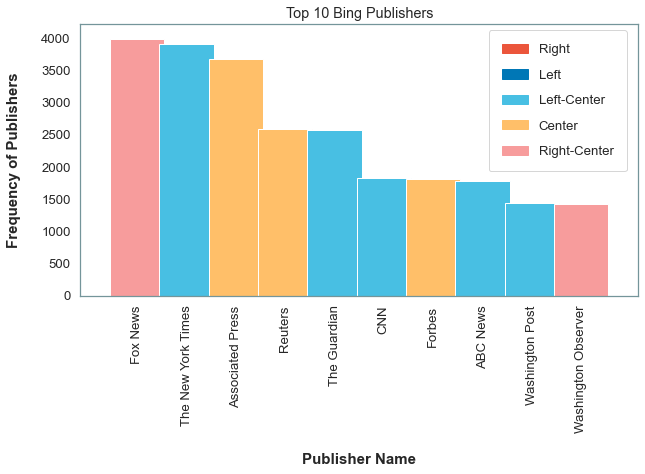

In [83]:
red_patch = mpatches.Patch(color='#eb553b', label='Right')
blue_patch = mpatches.Patch(color='#0077b6', label='Left')
pink_patch = mpatches.Patch(color='#f79c9c', label='Right-Center')
l_blue_patch = mpatches.Patch(color='#48bfe3', label='Left-Center')
green_patch = mpatches.Patch(color='#ffbf69', label='Center')

plt.figure(figsize=(10,5))
plt.xticks(rotation=70)
col = []

for i in comp_top_10_publishers_ratings['Ratings (Bing)']:
    if i == 'left':
        col.append("#0077b6")
    elif i == 'left-center':
        col.append("#48bfe3")
    elif i == 'right':
        col.append("#eb553b")
    elif i == 'right-center':
        col.append("#f79c9c")
    elif i == 'center':
        col.append('#ffbf69')
    else:
        col.append("grey")

plt.bar(
    range(len(comp_top_10_publishers_ratings)),
    comp_top_10_publishers_ratings['Frequency (Bing)'],
    tick_label=comp_top_10_publishers_ratings['Bing'],
    color = col, width = 1.1)

plt.title("Top 10 Bing Publishers")
plt.rcParams.update({'font.size': 12})
plt.xticks(rotation=90)

plt.grid(lw = 1, ls = '-', axis = 'x', color = '#C1A3A3')
plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})

plt.xlabel("Publisher Name", labelpad = 20, fontsize = 15, fontweight = 600)
plt.ylabel("Frequency of Publishers", labelpad = 20, fontsize = 15, fontweight = 600)

plt.legend(handles=[red_patch, blue_patch, l_blue_patch, green_patch, pink_patch], bbox_to_anchor=(0.72, 1), loc='upper left', borderpad  = 1, labelspacing = 1)
plt.margins(0.06)
plt.show()

In [84]:
google_publishers_raw = get_frequency_publishers('google', 15)
bing_publishers_raw = get_frequency_publishers('bing', 15)

In [85]:
news_wise_sentiment = defaultdict(list)
for publisher, freq in google_publishers_raw:
    temp = get_sentiment_for_publisher(publisher)
    publisher = publisher.replace('The ', '')
    news_wise_sentiment[publisher].append(temp)
for publisher, freq in bing_publishers_raw:
    temp = get_sentiment_for_publisher(publisher)
    publisher = publisher.replace(' on MSN.com', '')
    publisher = publisher.replace('The ', '')
    news_wise_sentiment[publisher].append(temp)
for publisher in news_wise_sentiment.keys():
    news_wise_sentiment[publisher] = sum(news_wise_sentiment[publisher])/len(news_wise_sentiment[publisher])


top_publisher_compare = []
publisher_sentiment = []
for publisher, sentiment in news_wise_sentiment.items():
    top_publisher_compare.append(publisher)
    publisher_sentiment.append(sentiment)
    
zipped_lists = zip(publisher_sentiment, top_publisher_compare)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
publisher_sentiment, top_publisher_compare = [ list(tuple) for tuple in  tuples]

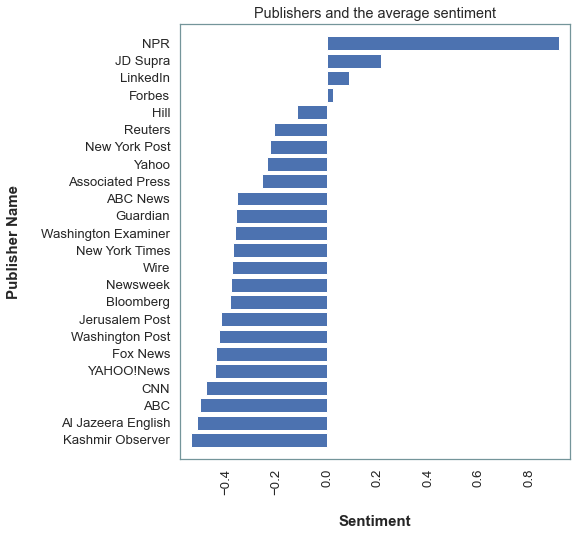

In [86]:
plt.figure(figsize=(7,8))
plt.xticks(rotation=70)
col = []

plt.barh(
    range(len(top_publisher_compare)),
    publisher_sentiment,
    tick_label=top_publisher_compare,
#     width = 0.7
)

plt.title("Publishers and the average sentiment")
plt.rcParams.update({'font.size': 12})
plt.xticks(rotation=90)

plt.grid(lw = 1, ls = '-', axis = 'y', color = '#ECECEC')
plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})

plt.xlabel("Sentiment", labelpad = 20, fontsize = 15, fontweight = 600)
plt.ylabel("Publisher Name", labelpad = 20, fontsize = 15, fontweight = 600)
plt.margins(0.03)
plt.show()

In [87]:
# For publishers on international issues

sentiment_intl_publisher_sentiment = []
sentiment_intl_publisher_name = []
for sentiment, publisher in get_sentiment_issue_wise('international', 10):
    sentiment_intl_publisher_sentiment.append(sentiment)
    sentiment_intl_publisher_name.append(publisher)
    
zipped_lists_2 = zip(sentiment_intl_publisher_sentiment, sentiment_intl_publisher_name)
sorted_pairs_2 = sorted(zipped_lists_2)

tuples_2 = zip(*sorted_pairs_2)
sentiment_intl_publisher_sentiment, sentiment_intl_publisher_name = [ list(tuple) for tuple in  tuples_2]

In [88]:
# For publishers on scientific issues

sentiment_scientific_publisher_sentiment = []
sentiment_scientific_publisher_name = []
for sentiment, publisher in get_sentiment_issue_wise('scientific', 10):
    sentiment_scientific_publisher_sentiment.append(sentiment)
    sentiment_scientific_publisher_name.append(publisher)
    
zipped_lists_4 = zip(sentiment_scientific_publisher_sentiment, sentiment_scientific_publisher_name)
sorted_pairs_4 = sorted(zipped_lists_4)

tuples_4 = zip(*sorted_pairs_4)
sentiment_scientific_publisher_sentiment, sentiment_scientific_publisher_name = [ list(tuple) for tuple in  tuples_4]

In [89]:
# For publishers on social issues

sentiment_social_publisher_sentiment = []
sentiment_social_publisher_name = []
for sentiment, publisher in get_sentiment_issue_wise('social', 10):
    sentiment_social_publisher_sentiment.append(sentiment)
    sentiment_social_publisher_name.append(publisher)
    
zipped_lists_3 = zip(sentiment_social_publisher_sentiment, sentiment_social_publisher_name)
sorted_pairs_3 = sorted(zipped_lists_3)

tuples_3 = zip(*sorted_pairs_3)
sentiment_social_publisher_sentiment, sentiment_social_publisher_name = [ list(tuple) for tuple in  tuples_3]

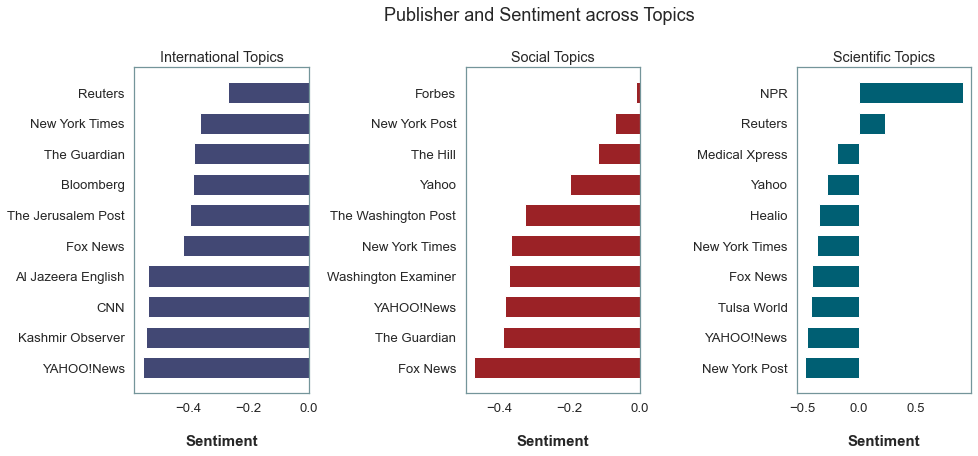

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 6))
fig.suptitle("Publisher and Sentiment across Topics", y = 1.02)
ax1.barh(
    range(len(sentiment_intl_publisher_name)),
    sentiment_intl_publisher_sentiment,
    tick_label=sentiment_intl_publisher_name,
    height = 0.7,
    color = '#424874'
)

ax2.barh(
    range(len(sentiment_social_publisher_name)),
    sentiment_social_publisher_sentiment,
    tick_label=sentiment_social_publisher_name,
    height = 0.7,
    color = "#9b2226"
)

ax3.barh(
    range(len(sentiment_scientific_publisher_name)),
    sentiment_scientific_publisher_sentiment,
    tick_label=sentiment_scientific_publisher_name,
    height = 0.7,
    color = "#005f73"
)

plt.subplots_adjust(wspace = 0.9)

ax1.set_title("International Topics")
ax2.set_title("Social Topics")
ax3.set_title("Scientific Topics")

plt.rcParams.update({'font.size': 12})

ax1.grid(lw = 1, ls = '-', axis = 'y', color = '#ECECEC')
ax2.grid(lw = 1, ls = '-', axis = 'y', color = '#ECECEC')
ax3.grid(lw = 1, ls = '-', axis = 'y', color = '#ECECEC')
ax1.grid(lw = 1, ls = '-', axis = 'x', color = '#ECECEC')
ax2.grid(lw = 1, ls = '-', axis = 'x', color = '#ECECEC')
ax3.grid(lw = 1, ls = '-', axis = 'x', color = '#ECECEC')


plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})

ax1.set_xlabel("Sentiment", labelpad = 20, fontsize = 15, fontweight = 600)
ax2.set_xlabel("Sentiment", labelpad = 20, fontsize = 15, fontweight = 600)
ax3.set_xlabel("Sentiment", labelpad = 20, fontsize = 15, fontweight = 600)

plt.show()

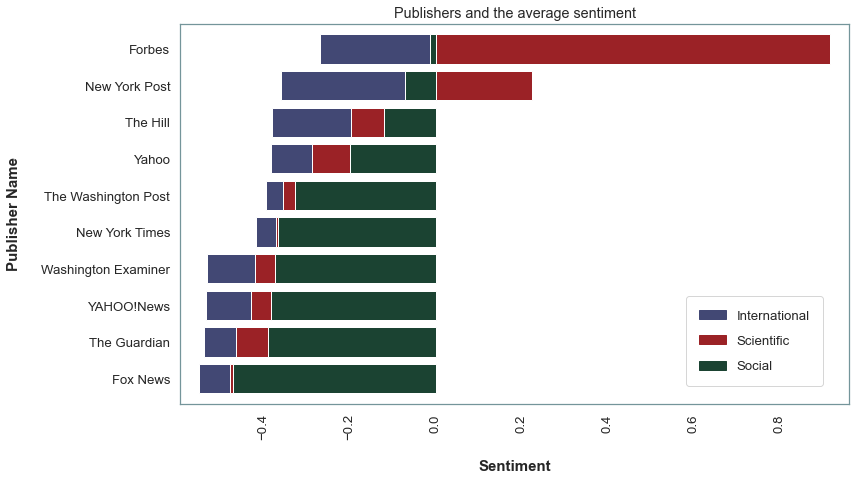

In [91]:
plt.figure(figsize=(12,7))
plt.xticks(rotation=70)

navy_intl = mpatches.Patch(color='#424874', label='International')
red_science = mpatches.Patch(color='#9b2226', label='Scientific')
green_social = mpatches.Patch(color='#1b4332', label='Social')

plt.barh(
    range(len(sentiment_intl_publisher_name)),
    sentiment_intl_publisher_sentiment,
    tick_label=sentiment_intl_publisher_name,
    color = "#424874" #blueNavy
)

plt.barh(
    range(len(sentiment_scientific_publisher_name)),
    sentiment_scientific_publisher_sentiment,
    tick_label=sentiment_scientific_publisher_name,
    color = "#9b2226" #red
)

plt.barh(
    range(len(sentiment_social_publisher_name)),
    sentiment_social_publisher_sentiment,
    tick_label=sentiment_social_publisher_name,
    color = "#1b4332" #green
)

plt.title("Publishers and the average sentiment")
plt.rcParams.update({'font.size': 12})
plt.xticks(rotation=90)

plt.grid(lw = 1, ls = '-', axis = 'y', color = '#ECECEC')
plt.rcParams.update({'font.size': 15, 'axes.facecolor': 'white', 'axes.edgecolor': '#74959A'})

plt.xlabel("Sentiment", labelpad = 20, fontsize = 15, fontweight = 600)
plt.ylabel("Publisher Name", labelpad = 20, fontsize = 15, fontweight = 600)
plt.margins(0.03)
plt.legend(handles=[navy_intl, red_science, green_social], bbox_to_anchor=(0.97, 0.3), borderpad  = 1, labelspacing = 1)

plt.show()

In [92]:
def get_length_sentiment_engine():
    myCursor.execute(
        'select total_chars, document_sentiment_num from '
        'news_sentiment where document_sentiment_num is not null and document_sentiment_num != 0.00;'
    )
    return myCursor.fetchall()

def get_favorite(limit):
    myCursor.execute(
        'select tweets.favorite_count, twitter_sentiment.document_sentiment_num from '
        'tweets inner join twitter_sentiment on tweets.tweet_id = twitter_sentiment.id '
        'where twitter_sentiment.document_sentiment_num != 0.00 and twitter_sentiment.document_sentiment_num is not null '
        f'and tweets.favorite_count < {limit}'
    )
    return myCursor.fetchall()

def get_retweet(limit):
    myCursor.execute(
        'select tweets.retweet_count, twitter_sentiment.document_sentiment_num from '
        'tweets inner join twitter_sentiment on tweets.tweet_id = twitter_sentiment.id '
        'where twitter_sentiment.document_sentiment_num != 0.00 and twitter_sentiment.document_sentiment_num is not null '
        f'and tweets.retweet_count < {limit}'
    )
    return myCursor.fetchall()

In [93]:
# length_sentiment_df = pd.DataFrame(get_length_sentiment_engine(), columns = ["Chars", "Sentiment"])
# length_sentiment_df["Sentiment"] = pd.to_numeric(length_sentiment_df["Sentiment"], downcast="float")
# fig, ax = plt.subplots(figsize = (10, 7))
# sns.regplot(y = length_sentiment_df["Sentiment"], x = length_sentiment_df["Chars"], ax=ax)
# # ax.set_xlim(1, 5000)
# plt.show()

In [94]:
# twitter_favorite = pd.DataFrame(get_favorite(5000), columns = ["Favorites", "Sentiment"])
# twitter_retweet = pd.DataFrame(get_retweet(1000), columns = ["Retweets", "Sentiment"])

# twitter_favorite["Sentiment"] = pd.to_numeric(twitter_favorite_retweet["Sentiment"], downcast="float")
# twitter_retweet["Sentiment"] = pd.to_numeric(twitter_favorite_retweet["Sentiment"], downcast="float")

In [95]:
# fig, ax = plt.subplots(figsize = (10, 7))
# sns.regplot(y = twitter_favorite["Sentiment"], x = twitter_favorite["Favorites"], ax=ax)
# # ax.set_xlim(1, 5000)
# plt.show()

In [96]:
# corr, p= pearsonr( twitter_favorite["Favorites"], twitter_favorite["Sentiment"])
# corr

In [97]:
# fig, ax = plt.subplots(figsize = (10, 7))
# sns.regplot(y = twitter_favorite_retweet["Sentiment"], x = twitter_favorite_retweet["Retweets"], ax=ax)
# ax.set_xlim(1, 5000)
# plt.show()

In [114]:
def get_avg_document_sentiment_engine_and_date(engine):
    '''
        Fetch the average document sentiment for the search engines.
    '''
    myCursor.execute(
        'select avg(news_sentiment.document_sentiment_num), news.published_date '
        'from news inner join news_sentiment on news.sentiment_id = news_sentiment.id '
        f'where news.search_engine = "{engine}" and news_sentiment.document_sentiment_num is not null group by news.published_date;'
    )
    return myCursor.fetchall()


In [130]:
sent_date, date_ = [], []
for s, d in get_avg_document_sentiment_engine_and_date('google'):
    sent_date.append(s)
    date_.append(d)
    
sent_dateb, date_b = [], []
for s, d in get_avg_document_sentiment_engine_and_date('bing'):
    sent_date.append(s)
    date_.append(d)

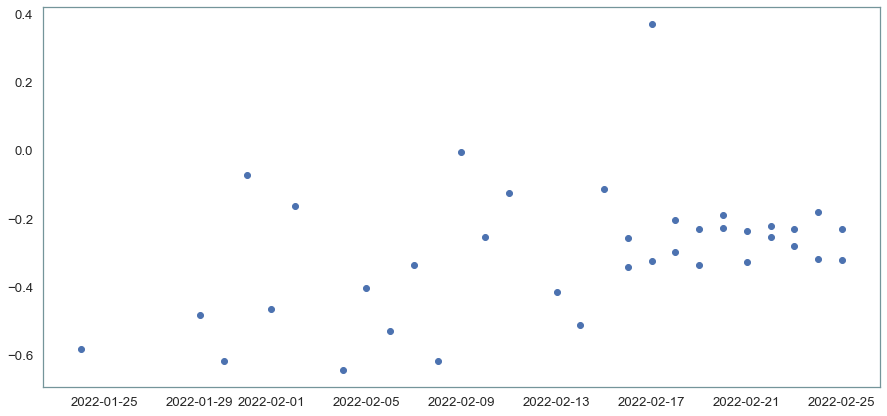

In [133]:
fig = plt.figure(figsize=(15, 5))
ax = fig.subplots()

plt.scatter(date_, sent_date)
plt.scatter(date_b, sent_dateb, c = 'red')